In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import ee # Google Earth Engine

In [2]:
# Force re-authentication
ee.Authenticate()

KeyboardInterrupt: Interrupted by user

In [3]:
PROJECT_ID = "miningcandb"  
ee.Initialize(project=PROJECT_ID) 
print("✅ Earth Engine is now initialized with project:", PROJECT_ID)

✅ Earth Engine is now initialized with project: miningcandb


# Clean and import datasets

In [4]:
# Canada SHP files
canada_boundary = gpd.read_file("data/Sources/Canada_boundary/Canada_boundary.shp")
canada_provinces = gpd.read_file("data/Sources/Canada_provinces_boundary/lpr_000b21a_e.shp")

In [5]:
# MinCan datasets
min_can_df = pd.read_csv(
    r'data/cleaned_data/min_can_cleaned_df.csv')

In [6]:
# NRCan datasets
nrcan_mining_df = pd.read_excel(
    r'data/NRCan/Principal Mineral Areas, Producing Mines, and Oil and Gas Fields (900A)/nrcan_mining_df.xlsx')
nrcan_manufacturing_df = pd.read_excel(
    r'data/NRCan/Principal Mineral Areas, Producing Mines, and Oil and Gas Fields (900A)/nrcan_manufacturing_df.xlsx')
nrcan_critical_df = pd.read_excel(
    r'data/NRCan/Critical minerals advanced projects, mines and processing facilities in Canada/Critical minerals advanced projects, mines and processing facilities.xlsx'
)

In [7]:
# GHG from large facilities datasets
ghg_facility_metal_mining_df = pd.read_csv(
    r'data/cleaned_data/ghg_facility_metal_mining_df.csv')
ghg_facility_metal_manufacturing_df = pd.read_csv(
    r'data/cleaned_data/ghg_facility_metal_manufacturing_df.csv')

In [8]:
# NPRI dataset
npri_metal_mining_df = pd.read_csv(
    r'data/cleaned_data/npri_metal_mining_df.csv')
npri_metal_manufacturing_df = pd.read_csv(
    r'data/cleaned_data/npri_metal_manufacturing_df.csv')

In [9]:
# Tailings dataset
tailings_source_df = pd.read_excel(
    r'data/Sources/WAPHA_global_metal_mines_database/GTD_Single_Table 4.0_March-2021.xlsx',
    skiprows=2
)
tailings_source_df = tailings_source_df[tailings_source_df['country'] == 'Canada']

In [10]:
# Climate Trace dataset
ctrace_annual = pd.read_csv(
    r'data/cleaned_data/ctrace_annual.csv')

# 1. a) Create parent table

## Create main table for facilities

In [99]:
from db_creation_function import check_duplicate_facilities

In [100]:
# We drop all industrial minerals from the mining dataset
nrcan_mining_df = nrcan_mining_df[nrcan_mining_df["COM_GROU_E"] != "Industrial minerals"]

In [101]:
# We keep only projects to avoid duplicates with the 900A dataset
# We also keep only active projects and remove past producer which are redundant with the 900A dataset
nrcan_critical_df = nrcan_critical_df[
    (nrcan_critical_df['OperationG'] == 'Project') &
    (nrcan_critical_df['ActivitySt'] == 'Active') &
    (nrcan_critical_df['Developmen'] != 'Past producer')
]


In [102]:
from db_creation_function import populate_table_df, assign_id

In [103]:
# We first create an empty df with the columns we want to have in the facility_df
main_columns = {
    #"facility_id": "text",
    "facility_name": "text",
    "reported_company": "text",
    "longitude": "float",
    "latitude": "float",
    "city": "text", # not specified in the project df 
    "province": "text",
    "status": "text", # active or projects 
    "activity_status": "text", # only for projects
    "development_stage": "text", # only for projects
    "facility_type": "text", # mining, manufacturing or projects
    "mining_processing_type": "text",
    "commodity_group": "text",
    "primary_commodity": "text",
    "commodities": "text",
    "source": "text"  
}

main_df = pd.DataFrame(columns=main_columns.keys())
main_df

,facility_name,reported_company,longitude,latitude,city,province,status,activity_status,development_stage,facility_type,mining_processing_type,commodity_group,primary_commodity,commodities,source


In [104]:
column_mapping_main = {
    
      "nrcan_mining_df": {
        "OPERATIO_E": "facility_name",
        "OWNER_E": "reported_company",
        "LONGITUDE": "longitude",
        "LATITUDE": "latitude",
        "CITY_E": "city",
        "PROVINCE_E": "province",
        "FAC_DESC_E": "mining_processing_type",
        "COM_GROU_E": "commodity_group", 
        "COM_DESC_E": "commodities"
        
    },
    "nrcan_manufacturing_df": {
        "OPERATIO_E": "facility_name",
        "OWNER_E": "reported_company",
        "LONGITUDE": "longitude",
        "LATITUDE": "latitude",
        "PROVINCE_E": "province",
        "FAC_TYPE_E": "mining_processing_type",
        "COM_GROU_E": "commodity_group",
        "COM_DESC_E": "commodities"
    }, 
    
    
    "nrcan_critical_df": {
        "PropertyNa": "facility_name",
        "OperatorOw": "reported_company",
        "Longitude": "longitude",
        "Latitude": "latitude",
        "ProvincesE": "province",
        "Developmen": "development_stage",
        "ActivitySt": "activity_status",
        "Commoditie": "commodities",
    }
}

In [105]:
main_df = populate_table_df(column_mapping_main, 
                                   main_df, 
                                   dynamic_columns = {
                                       "facility_type": {
                                           "nrcan_mining_df": "mining",
                                            "nrcan_manufacturing_df": "manufacturing",
                                           "nrcan_critical_df": "project"
                                                           },
                                       "status": {
                                            "nrcan_mining_df": "active_facility",
                                            "nrcan_manufacturing_df": "active_facility",
                                            "nrcan_critical_df": "project_facility"
                                                           },
                                                      }, 
                            
                                   source_dfs = {"nrcan_mining_df": nrcan_mining_df,
                                                 "nrcan_manufacturing_df": nrcan_manufacturing_df,
                                                 "nrcan_critical_df": nrcan_critical_df}
                                   )

Initial facility_df rows: 0
Processing DataFrame: nrcan_mining_df
Temp DF rows to append: 113
Rows in facility_df after appending nrcan_mining_df: 113
Processing DataFrame: nrcan_manufacturing_df
Temp DF rows to append: 73
Rows in facility_df after appending nrcan_manufacturing_df: 186
Processing DataFrame: nrcan_critical_df
Temp DF rows to append: 142
Rows in facility_df after appending nrcan_critical_df: 328
Final facility_df rows: 328


C:\Users\mp_ma\OneDrive - polymtlus\Desktop\POST_DOC\Project\canada_metal_sustainability_db\db_creation_function.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  facility_df = pd.concat([facility_df, temp_df], ignore_index=True)


In [106]:
# Compute primary_commodity from commodities
if "commodities" in main_df.columns:
    main_df["primary_commodity"] = main_df["commodities"].apply(
            lambda x: x.split(",")[0].strip() if isinstance(x, str) and x else None
        )

In [129]:
main_gdf = assign_id(
    main_df,
    canada_provinces,
    id_column = "main_id",
    prefix='MAIN'
)
main_gdf

,main_id,facility_name,reported_company,longitude,latitude,city,province,status,activity_status,development_stage,facility_type,mining_processing_type,commodity_group,primary_commodity,commodities,source,source_df,geometry
0,NL-MAIN-251d6364,Beaver Brook,China Minmetals Rare Earth Group Co. Ltd.,-55.196000,48.715909,Glenwood,Newfoundland and Labrador,active_facility,NaN,NaN,mining,"Underground, concentrator",Other metals,Antimony,Antimony,NaN,nrcan_mining_df,POINT (-55.19600 48.71591)
1,NL-MAIN-842ba1b4,Nugget Pond,FireFly Metals Ltd.,-55.775300,49.845000,Snook’s Arm,Newfoundland and Labrador,active_facility,NaN,NaN,mining,Concentrator,Base metals,Copper,Copper,NaN,nrcan_mining_df,POINT (-55.77530 49.84500)
2,NL-MAIN-c139de6d,Ming,FireFly Metals Ltd.,-56.087000,49.915000,Baie Verte,Newfoundland and Labrador,active_facility,NaN,NaN,mining,Underground,Base metals,Copper,"Copper, gold, silver",NaN,nrcan_mining_df,POINT (-56.08700 49.91500)
3,NL-MAIN-f021107e,Point Rousse,Maritime Resources Corp.,-56.124447,49.961420,Baie Verte,Newfoundland and Labrador,active_facility,NaN,NaN,mining,"Open-pit, concentrator",Precious metals,Gold,Gold,NaN,nrcan_mining_df,POINT (-56.12445 49.96142)
4,NL-MAIN-2d8801d6,Voisey’s Bay,Vale Newfoundland and Labrador Limited,-62.090855,56.331659,Voisey’s Bay,Newfoundland and Labrador,active_facility,NaN,NaN,mining,"Open-pit, underground, concentrator",Base metals,Nickel,"Nickel, copper, cobalt",NaN,nrcan_mining_df,POINT (-62.09085 56.33166)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,NB-MAIN-0c5b40d8,Nash Creek,Callinex Mines Inc.,-66.097710,47.889390,NaN,New Brunswick,project_facility,Active,Advanced project,project,NaN,NaN,Zinc,"Zinc, lead, silver",NaN,nrcan_critical_df,POINT (-66.09771 47.88939)
324,NT-MAIN-b3681e03,Prairie Creek,NorZinc Ltd.,-124.799380,61.557130,NaN,Northwest Territories,project_facility,Active,Advanced project,project,NaN,NaN,Zinc,"Zinc, lead, silver",NaN,nrcan_critical_df,POINT (-124.79938 61.55713)
325,NB-MAIN-8e04eb21,Murray Brook,Canadian Copper,-66.431670,47.525280,NaN,New Brunswick,project_facility,Active,Advanced project,project,NaN,NaN,Zinc,"Zinc, lead, silver, copper, gold",NaN,nrcan_critical_df,POINT (-66.43167 47.52528)
326,QC-MAIN-5801b453,Abcourt-Barvue,Abcourt Mines Inc.,-77.679010,48.521540,NaN,Quebec,project_facility,Active,Advanced project,project,NaN,NaN,Zinc,"Zinc, silver",NaN,nrcan_critical_df,POINT (-77.67901 48.52154)


In [135]:
main_gdf = main_gdf.sort_values(by=["reported_company", "facility_name"]).reset_index(drop=True)
main_gdf

,main_id,facility_name,reported_company,longitude,latitude,city,province,status,activity_status,development_stage,facility_type,mining_processing_type,commodity_group,primary_commodity,commodities,source,source_df,geometry
0,QC-MAIN-5801b453,Abcourt-Barvue,Abcourt Mines Inc.,-77.679010,48.521540,NaN,Quebec,project_facility,Active,Advanced project,project,NaN,NaN,Zinc,"Zinc, silver",NaN,nrcan_critical_df,POINT (-77.67901 48.52154)
1,QC-MAIN-d29e0839,Sleeping Giant,Abcourt Mines Inc.,-77.974340,49.132590,north of Amos,Quebec,active_facility,NaN,NaN,mining,Concentrator,Precious metals,Gold,"Gold, silver",NaN,nrcan_mining_df,POINT (-77.97434 49.13259)
2,QC-MAIN-f1ff4920,Akasaba West,Agnico Eagle Mines Limited,-77.580000,48.040000,NaN,Quebec,project_facility,Active,Advanced project,project,NaN,NaN,Gold,"Gold, copper",NaN,nrcan_critical_df,POINT (-77.58000 48.04000)
3,NU-MAIN-4ea8ac9d,Amaruq,Agnico Eagle Mines Limited,-96.697000,65.415000,Baker Lake,Nunavut,active_facility,NaN,NaN,mining,"Open-pit, underground",Precious metals,Gold,Gold,NaN,nrcan_mining_df,POINT (-96.69700 65.41500)
4,QC-MAIN-e7e6a960,Canadian Malartic,Agnico Eagle Mines Limited,-78.130824,48.122223,Malartic,Quebec,active_facility,NaN,NaN,mining,"Open-pit, concentrator",Precious metals,Gold,"Gold, silver",NaN,nrcan_mining_df,POINT (-78.13082 48.12222)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,AB-MAIN-526c6c76,Genesee,Westmoreland Coal Company,-114.267236,53.323876,Genesee,Alberta,active_facility,NaN,NaN,mining,Open-pit,Coal,Coal (thermal),Coal (thermal),NaN,nrcan_mining_df,POINT (-114.26724 53.32388)
324,SK-MAIN-a35bfc1b,Poplar River,Westmoreland Coal Company,-105.472585,49.217566,Coronach,Saskatchewan,active_facility,NaN,NaN,mining,Open-pit,Coal,Coal (thermal),Coal (thermal),NaN,nrcan_mining_df,POINT (-105.47258 49.21757)
325,ON-MAIN-12c68d49,Eagle's Nest,Wyloo,-86.303800,52.742020,NaN,Ontario,project_facility,Active,Advanced project,project,NaN,NaN,Nickel,"Nickel, copper, gold, platinum, palladium",NaN,nrcan_critical_df,POINT (-86.30380 52.74202)
326,SK-MAIN-bae48393,Southey,"Yancoal Canada Resosurces Co., ltd.",-104.659790,51.114660,NaN,Saskatchewan,project_facility,Active,Advanced project,project,NaN,NaN,Potash,Potash,NaN,nrcan_critical_df,POINT (-104.65979 51.11466)


In [108]:
# We make sure there is no duplicate
duplicates_main_gdf = check_duplicate_facilities(main_gdf)
duplicates_main_gdf

,main_id,facility_name,reported_company,longitude,latitude,city,province,status,activity_status,development_stage,facility_type,mining_processing_type,commodity_group,primary_commodity,commodities,source,source_df,geometry


In [109]:
main_gdf['facility_type'].value_counts()

facility_type
project          142
mining           113
manufacturing     73
Name: count, dtype: int64

In [110]:
main_gdf.to_file(r'data/Tables/GeoJSON/main_gdf.geojson', driver="GeoJSON")
main_gdf.to_csv(r'data/Tables/CSV/main_gdf.csv', index=False)

This is the parent table, composed of 114 mines, 73 manufacturing sites and 142 projects.

## Create IDs for companies and facility groups

In [90]:
from db_creation_function import assign_deterministic_id

ImportError: cannot import name 'assign_deterministic_id' from 'db_creation_function' (C:\Users\mp_ma\OneDrive - polymtlus\Desktop\POST_DOC\Project\canada_metal_sustainability_db\db_creation_function.py)

In [121]:
companies_df = pd.read_excel(r'data/Tables/ID_to_create.xlsx', sheet_name='companies')
facility_groups_df = pd.read_excel(r'data/Tables/ID_to_create.xlsx', sheet_name='facility_groups')

In [122]:
companies_df = assign_deterministic_id(companies_df, 'CMP-', 'company_name_folder', 'company_id')
companies_df

,company_name_folder,reported_company,facility_name,main_id,status,company_id
0,Abcourt Mines Inc,Abcourt Mines Inc.,Abcourt-Barvue,QC-MAIN-5801b453,project_facility,CMP-0a6a3062
1,Abcourt Mines Inc,Abcourt Mines Inc.,Sleeping Giant,QC-MAIN-d29e0839,active_facility,CMP-0a6a3062
2,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Akasaba West,QC-MAIN-f1ff4920,project_facility,CMP-6265c407
3,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Amaruq,QC-MAIN-c0660aec,active_facility,CMP-6265c407
4,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Canadian Malartic,ON-MAIN-1f126a43,active_facility,CMP-6265c407
...,...,...,...,...,...,...
323,Westmoreland Coal Company,Westmoreland Coal Company,Genesee,AB-MAIN-526c6c76,active_facility,CMP-14aa336a
324,Westmoreland Coal Company,Westmoreland Coal Company,Poplar River,AB-MAIN-0c614cfb,active_facility,CMP-14aa336a
325,Wyloo,Wyloo,Eagle's Nest,ON-MAIN-12c68d49,project_facility,CMP-65b36728
326,"Yancoal Canada Resosurces Co., ltd","Yancoal Canada Resosurces Co., ltd.",Southey,SK-MAIN-bae48393,project_facility,CMP-024fb0c1


In [123]:
# To see the number of facilities per companies
active_facility_counts = (
    companies_df[companies_df["status"] == "active_facility"]
    .groupby(["company_id", "company_name_folder"])
    .size()
    .reset_index(name="active_facility_count")
    .sort_values(by="active_facility_count", ascending=False)
)
active_facility_counts

,company_id,company_name_folder,active_facility_count
54,CMP-9dd4e461,x,12
50,CMP-9617aef4,Vale,11
44,CMP-7a096012,Rio Tinto,10
67,CMP-d5f1c66b,Glencore,10
34,CMP-6265c407,Agnico Eagle Mines Limited,8
...,...,...,...
46,CMP-84fc7d46,Baffinland Iron Mines Corporation,1
47,CMP-858cc590,Maritime Resources Corp,1
48,CMP-89ae3b2b,Elkem Metal Canada Inc,1
49,CMP-8a99044e,Tacora Resources Inc,1


In [124]:
facility_groups_df = assign_deterministic_id(facility_groups_df, 'GRP-', 'facility_group_name', 'facility_group_id')
facility_groups_df

,reported_company,facility_name,main_id,facility_group_name,facility_group_id
0,Agnico Eagle Mines Limited,Amaruq,QC-MAIN-c0660aec,Meadowbank complex,GRP-0a2c0d69
1,Agnico Eagle Mines Limited,Meadowbank,QC-MAIN-e51eda66,Meadowbank complex,GRP-0a2c0d69
2,Cameco Corporation,Key Lake,SK-MAIN-d3c471e8,Key Lake + McArthur River,GRP-21eee27d
3,Cameco Corporation,McArthur River,SK-MAIN-bb89158f,Key Lake + McArthur River,GRP-21eee27d
4,Glencore Canada Corporation,Nickel Rim South,ON-MAIN-fcb287a4,Sudbury INO,GRP-1437e854
5,Glencore Canada Corporation,Strathcona,ON-MAIN-206041d1,Sudbury INO,GRP-1437e854
6,Glencore Canada Corporation,Fraser,ON-MAIN-ed85ac94,Sudbury INO,GRP-1437e854
7,Hudbay Minerals Inc.,New Britannia,MB-MAIN-0898e255,Snow Lake,GRP-a13779f8
8,Hudbay Minerals Inc.,Stall Lake,MB-MAIN-da0b5c3d,Snow Lake,GRP-a13779f8
9,Hudbay Minerals Inc.,Lalor Lake,MB-MAIN-be5b3dc8,Snow Lake,GRP-a13779f8


In [125]:
companies_df = companies_df.merge(
    facility_groups_df[["main_id", "facility_group_name", "facility_group_id"]].drop_duplicates(),
    on="main_id",
    how="left"
)

In [126]:
companies_df

,company_name_folder,reported_company,facility_name,main_id,status,company_id,facility_group_name,facility_group_id
0,Abcourt Mines Inc,Abcourt Mines Inc.,Abcourt-Barvue,QC-MAIN-5801b453,project_facility,CMP-0a6a3062,NaN,NaN
1,Abcourt Mines Inc,Abcourt Mines Inc.,Sleeping Giant,QC-MAIN-d29e0839,active_facility,CMP-0a6a3062,NaN,NaN
2,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Akasaba West,QC-MAIN-f1ff4920,project_facility,CMP-6265c407,NaN,NaN
3,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Amaruq,QC-MAIN-c0660aec,active_facility,CMP-6265c407,Meadowbank complex,GRP-0a2c0d69
4,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Canadian Malartic,ON-MAIN-1f126a43,active_facility,CMP-6265c407,NaN,NaN
...,...,...,...,...,...,...,...,...
323,Westmoreland Coal Company,Westmoreland Coal Company,Genesee,AB-MAIN-526c6c76,active_facility,CMP-14aa336a,NaN,NaN
324,Westmoreland Coal Company,Westmoreland Coal Company,Poplar River,AB-MAIN-0c614cfb,active_facility,CMP-14aa336a,NaN,NaN
325,Wyloo,Wyloo,Eagle's Nest,ON-MAIN-12c68d49,project_facility,CMP-65b36728,NaN,NaN
326,"Yancoal Canada Resosurces Co., ltd","Yancoal Canada Resosurces Co., ltd.",Southey,SK-MAIN-bae48393,project_facility,CMP-024fb0c1,NaN,NaN


In [128]:
companies_df.to_excel(r'data/Tables/ID_created.xlsx', index=False)

### Merge the created IDs into the main_gdf

In [95]:
main_gdf = main_gdf.merge(
    companies_df[["reported_company", "company_name_folder", "company_id"]].drop_duplicates(),
    on="reported_company",
    how="left"
)


In [96]:
main_gdf = main_gdf.merge(
    facility_groups_df[["main_id", "facility_group_name", "facility_group_id"]].drop_duplicates(),
    on="main_id",
    how="left"
)

In [97]:
main_gdf

,main_id,facility_name,reported_company,longitude,latitude,city,province,status,activity_status,development_stage,...,mining_processing_type,commodity_group,primary_commodity,commodities,source,source_df,geometry,company_name_folder,company_id,facility_group_id
0,NL-MAIN-251d6364,Beaver Brook,China Minmetals Rare Earth Group Co. Ltd.,-55.196000,48.715909,Glenwood,Newfoundland and Labrador,active_facility,NaN,NaN,...,"Underground, concentrator",Other metals,Antimony,Antimony,NaN,nrcan_mining_df,POINT (-55.19600 48.71591),x,CMP-9dd4e461,NaN
1,NL-MAIN-842ba1b4,Nugget Pond,FireFly Metals Ltd.,-55.775300,49.845000,Snook’s Arm,Newfoundland and Labrador,active_facility,NaN,NaN,...,Concentrator,Base metals,Copper,Copper,NaN,nrcan_mining_df,POINT (-55.77530 49.84500),FireFly Metals Ltd,CMP-24a4f1d5,NaN
2,NL-MAIN-c139de6d,Ming,FireFly Metals Ltd.,-56.087000,49.915000,Baie Verte,Newfoundland and Labrador,active_facility,NaN,NaN,...,Underground,Base metals,Copper,"Copper, gold, silver",NaN,nrcan_mining_df,POINT (-56.08700 49.91500),FireFly Metals Ltd,CMP-24a4f1d5,NaN
3,NL-MAIN-f021107e,Point Rousse,Maritime Resources Corp.,-56.124447,49.961420,Baie Verte,Newfoundland and Labrador,active_facility,NaN,NaN,...,"Open-pit, concentrator",Precious metals,Gold,Gold,NaN,nrcan_mining_df,POINT (-56.12445 49.96142),Maritime Resources Corp,CMP-858cc590,NaN
4,NL-MAIN-2d8801d6,Voisey’s Bay,Vale Newfoundland and Labrador Limited,-62.090855,56.331659,Voisey’s Bay,Newfoundland and Labrador,active_facility,NaN,NaN,...,"Open-pit, underground, concentrator",Base metals,Nickel,"Nickel, copper, cobalt",NaN,nrcan_mining_df,POINT (-62.09085 56.33166),Vale,CMP-9617aef4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,NB-MAIN-0c5b40d8,Nash Creek,Callinex Mines Inc.,-66.097710,47.889390,NaN,New Brunswick,project_facility,Active,Advanced project,...,NaN,NaN,Zinc,"Zinc, lead, silver",NaN,nrcan_critical_df,POINT (-66.09771 47.88939),NaN,None,NaN
324,NT-MAIN-b3681e03,Prairie Creek,NorZinc Ltd.,-124.799380,61.557130,NaN,Northwest Territories,project_facility,Active,Advanced project,...,NaN,NaN,Zinc,"Zinc, lead, silver",NaN,nrcan_critical_df,POINT (-124.79938 61.55713),NorZinc Ltd,CMP-ef31182b,NaN
325,NB-MAIN-8e04eb21,Murray Brook,Canadian Copper,-66.431670,47.525280,NaN,New Brunswick,project_facility,Active,Advanced project,...,NaN,NaN,Zinc,"Zinc, lead, silver, copper, gold",NaN,nrcan_critical_df,POINT (-66.43167 47.52528),NaN,None,NaN
326,QC-MAIN-5801b453,Abcourt-Barvue,Abcourt Mines Inc.,-77.679010,48.521540,NaN,Quebec,project_facility,Active,Advanced project,...,NaN,NaN,Zinc,"Zinc, silver",NaN,nrcan_critical_df,POINT (-77.67901 48.52154),Abcourt Mines Inc,CMP-0a6a3062,NaN


In [98]:
main_gdf.to_file(r'data/Tables/GeoJSON/main_gdf.geojson', driver="GeoJSON")
main_gdf.to_csv(r'data/Tables/CSV/main_gdf.csv', index=False)

# 1.b) Create children tables

In [40]:
from db_creation_function import add_year, assign_row_id

## Children tables with coordinates

### Create tailings table

In [39]:
# We first create an empty df with the columns we want to have in the facility_df
tailings_columns = {
    #"facility_id": "text",
    "tsf_name": "text",
    "related_mine": "text",
    "main_owner": "text",
    "full_ownership": "text",
    "operator": "text",
    "longitude": "float",
    "latitude": "float",
    "status": "text", 
    "construction_year": "int",
    "raise_type": "text",	
    "current_maximum_height": "int",	
    "current_tailings_storage": "int",	
    "planned_storage_5_years": "int",
    "hazard_categorization": "text",
    "classification_system": "text",
    "link": "text",
    "source": "text"  
}

tailings_df = pd.DataFrame(columns=tailings_columns.keys())
tailings_df

,tsf_name,related_mine,main_owner,full_ownership,operator,longitude,latitude,status,construction_year,raise_type,current_maximum_height,current_tailings_storage,planned_storage_5_years,hazard_categorization,classification_system,link,source


In [40]:
column_mapping_tailings = {
    "tailings_source_df": {
    "tsf": "tsf_name",
    "mine": "related_mine",
    "Owner_company": "main_owner",
    "partners (not from disclosure)": "full_ownership",
    "operator": "operator",
    "longitude": "longitude",
    "latitude": "latitude",
    "status": "status", 
    "construction_year": "construction_year",
    "raise_type": "raise_type",	
    "current_maximum_height": "current_maximum_height",	
    "current_tailings_storage": "current_tailings_storage",	
    "planned_storage_5_years": "planned_storage_5_years",
    "hazard_categorization": "hazard_categorization",
    "classification_system": "classification_system",
    "link": "link"
    }
}

In [41]:
tailings_df = populate_table_df(column_mapping_tailings, 
                                   tailings_df, 
                                   source_dfs = {"tailings_source_df": tailings_source_df}
                                   )

Initial facility_df rows: 0
Processing DataFrame: tailings_source_df
Temp DF rows to append: 227
Rows in facility_df after appending tailings_source_df: 227
Final facility_df rows: 227


C:\Users\mp_ma\OneDrive - polymtlus\Desktop\POST_DOC\Project\canada_metal_sustainability_db\db_creation_function.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  facility_df = pd.concat([facility_df, temp_df], ignore_index=True)


In [42]:
tailings_gdf = assign_id(tailings_df, canada_provinces, id_column='tailing_id', prefix='TAIL', name_col="tsf_name")

In [43]:
tailings_gdf = add_year(tailings_gdf, 2019)

In [44]:
tailings_gdf = assign_row_id(tailings_gdf, 
                  facility_id_col='tailing_id',
                  prefix='TAIL',
                  year_col='year'           
                  )

In [45]:
tailings_gdf

,row_id,year,tailing_id,tsf_name,related_mine,main_owner,full_ownership,operator,longitude,latitude,...,raise_type,current_maximum_height,current_tailings_storage,planned_storage_5_years,hazard_categorization,classification_system,link,source,source_df,geometry
0,TAIL-ce1b28f4-2019-1,2019,NU-TAIL-ce1b28f4,North Cell,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.043328,65.021558,...,"Downstream, Upstream",31.0,14400000,14400000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,tailings_source_df,POINT (-96.04333 65.02156)
1,TAIL-46b364c0-2019-1,2019,NU-TAIL-46b364c0,South Cell,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.033391,65.013782,...,Downstream,49.0,10420000,10800000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,tailings_source_df,POINT (-96.03339 65.01378)
2,TAIL-6612fa3a-2019-1,2019,NU-TAIL-6612fa3a,In pit,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.032544,65.001901,...,NaN,NaN,850000,12500000,Low,NaN,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,tailings_source_df,POINT (-96.03254 65.00190)
3,TAIL-f33b3dac-2019-1,2019,NU-TAIL-f33b3dac,Meliadine TSF,Meliadine,Agnico Eagle,NaN,Agnico Eagle,-92.140336,63.020829,...,NaN,5.0,89000,4354000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,tailings_source_df,POINT (-92.14034 63.02083)
4,TAIL-bb8684fa-2019-1,2019,QC-TAIL-bb8684fa,South TSF,Goldex,Agnico Eagle,NaN,Agnico Eagle,-77.841978,48.054342,...,Not Raised,5.0,1664000,2500000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,tailings_source_df,POINT (-77.84198 48.05434)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,TAIL-547aba47-2019-1,2019,BC-TAIL-547aba47,TMA,Equity Silver,Newmont Goldcorp,NaN,Newmont/Goldcorp,-126.269100,54.204300,...,"Downstream, centreline",61.0,48000000,NaN,Very High,Canadian Dam Association,https://www.newmontgoldcorp.com/document/churc...,NaN,tailings_source_df,POINT (-126.26910 54.20430)
223,TAIL-7791ece7-2019-1,2019,NT-TAIL-7791ece7,Upper Pud,Miramar - Con Mine,Newmont Goldcorp,NaN,Miramar,-114.376300,62.430800,...,"Upstream, Centreline",13.0,1550000,NaN,Low,Canadian Dam Association,https://www.newmontgoldcorp.com/document/churc...,NaN,tailings_source_df,POINT (-114.37630 62.43080)
224,TAIL-c0247868-2019-1,2019,NT-TAIL-c0247868,Middle Pud,Miramar - Con Mine,Newmont Goldcorp,NaN,Miramar,-114.376300,62.430800,...,Upstream,7.0,930000,NaN,Low,Canadian Dam Association,https://www.newmontgoldcorp.com/document/churc...,NaN,tailings_source_df,POINT (-114.37630 62.43080)
225,TAIL-fee10612-2019-1,2019,NT-TAIL-fee10612,"Lower Pud, Neil Lake and Neques TCAs",Miramar - Con Mine,Newmont Goldcorp,NaN,Miramar,-114.376300,62.430800,...,Upstream,1.5,620000,NaN,Low,Canadian Dam Association,https://www.newmontgoldcorp.com/document/churc...,NaN,tailings_source_df,POINT (-114.37630 62.43080)


### Create ClimateTRACE table

In [46]:
# # # Let's choose the year 2023
# ctrace_df = ctrace_annual[ctrace_annual['year'] == 2023]
# ctrace_df = ctrace_df.drop(columns='year').reset_index(drop=True)

In [47]:
# # # We rename geometry columns for ID assignation
# ctrace_df = ctrace_df.rename(columns={
#     'lat': 'latitude',
#     'lon': 'longitude',
# }
# )

In [48]:
# ctrace_df

In [49]:
# # ctrace_gdf = assign_id(
#     ctrace_df, 
#     canada_provinces,
#     id_column = 'climate_trace_id',
#     prefix="CTRACE")

In [50]:
# ctrace_gdf = add_year(ctrace_gdf, 2023)

In [51]:
# ctrace_gdf

In [52]:
# ctrace_gdf.to_file(r'data/Tables/GeoJSON/ctrace_gdf.geojson', driver="GeoJSON")
#ctrace_gdf.to_csv(r'data/Tables/CSV/ctrace_gdf.csv', index=False)

### Create MinCan table 

In [53]:
min_can_gdf = assign_id(min_can_df, 
                              canada_provinces = canada_provinces,
                              id_column="mincan_id", prefix="MINCAN",
                              name_col='namemine')

In [54]:
# To change later, but to avoid having duplicates IDs
min_can_gdf = min_can_gdf.drop_duplicates(subset=['mincan_id'])

In [55]:
def combine_periods(row):
    periods = []
    for i in range(1, 4):
        open_col = f"open{i}"
        close_col = f"close{i}"
        open_val = str(row[open_col]) if pd.notna(row[open_col]) else ""
        close_val = str(row[close_col]) if pd.notna(row[close_col]) else ""
        if open_val and close_val:
            periods.append(f"{open_val}–{close_val}")
        elif open_val:
            periods.append(f"{open_val}–")
        elif close_val:
            periods.append(f"–{close_val}")
    return "; ".join(periods) if periods else None

In [56]:
min_can_gdf["operation_periods"] = min_can_gdf.apply(combine_periods, axis=1)

In [57]:
columns_to_drop = [f"company{i}" for i in range(1, 7)] + \
                  [f"open{i}" for i in range(1, 4)] + \
                  [f"close{i}" for i in range(1, 4)] + \
                  [f"source{i}" for i in range(1, 4)] + \
                  [f"link{i}" for i in range(1, 4)]
min_can_gdf = min_can_gdf.drop(columns=columns_to_drop)

In [58]:
min_can_gdf

,mincan_id,namemine,town,province,latitude,longitude,commodityall,information,mine_status,geometry,operation_periods
0,QC-MINCAN-a8c87336,NaN,NaN,Quebec,45.263786,-72.331764,"Copper, Gold, Silver",NaN,Inactive,POINT (-72.33176 45.26379),1866–1958
1,BC-MINCAN-16652987,Spruce Creek,Atlin,British Columbia,59.382720,-133.270330,Gold,NaN,Inactive,POINT (-133.27033 59.38272),1909–1950; 1955–1989
2,BC-MINCAN-d675705f,Wesfrob (Tasu),Moresby Island,British Columbia,52.758340,-132.050000,"Iron, Copper",NaN,Inactive,POINT (-132.05000 52.75834),1914–1983
3,NS-MINCAN-ca20ef49,NaN,NaN,Nova Scotia,45.550219,-62.566780,Coal,The currently entered coordinates are for the ...,Inactive,POINT (-62.56678 45.55022),1918–1966
4,QC-MINCAN-d1e8b6b1,Horne,Noranda,Quebec,48.254270,-79.011280,"Copper, Gold, Silver, Selenium, Tellurium, Pyr...",Alternative names: Horne Mine (1975) The mine ...,Inactive,POINT (-79.01128 48.25427),1927–1976
...,...,...,...,...,...,...,...,...,...,...,...
942,BC-MINCAN-4611f856,Huckleberry,Kemano,British Columbia,53.681110,-127.178050,"Copper, Molybdenum, Silver, Gold",NaN,Inactive,POINT (-127.17805 53.68111),1997–2016
943,NT-MINCAN-ea720725,Panda (Ekati Project),Lac de Gras,Northwest Territories,64.716667,-110.608333,Diamond,Brief closure between 2020 and 2021,Active,POINT (-110.60833 64.71667),1997–open
944,QC-MINCAN-8f0f7e05,Ardorbec,Danville,Quebec,45.748462,-71.961305,Magnesium,NaN,Active,POINT (-71.96130 45.74846),1998–open
945,QC-MINCAN-54661244,Jeffrey,Asbestos (Val-des-Sources),Quebec,45.775100,-71.947600,Chrysotile,"FR: En 1992, la mine est l'objet d'une importa...",Inactive,POINT (-71.94760 45.77510),1879–2009


### Create GHG table

In [59]:
# We first create an empty df with the columns we want to have in the ghg_df
ghg_columns = {
    "facility_name_ghg": "text",
    "longitude": "float",   
    "latitude": "float",
    "city": "text",
    "province": "text",
    "year": "integer",
    "sector": "text",
    "value": "float",
    "unit": "text", # column 
    "facility_url" : "url" # column Facility information
}

ghg_df = pd.DataFrame(columns=ghg_columns.keys())
ghg_df

,facility_name_ghg,longitude,latitude,city,province,year,sector,value,unit,facility_url


In [60]:
# Based on concordances tables
column_mapping_ghg = {
    "ghg_facility_metal_mining_df": {
        "Facility name": "facility_name_ghg",
        "Latitude": "latitude",
        "Longitude": "longitude",
        "City": "city",
        "Province": "province",
        "Report year": "year",
        "Industry classification": "sector",
        "Total emissions": "value",
        "Units": "unit",
        "Facility information": "facility_url",
 
    },
    
    "ghg_facility_metal_manufacturing_df": {
        "Facility name": "facility_name_ghg",
        "Latitude": "latitude",
        "Longitude": "longitude",
        "City": "city",
        "Province": "province",
        "Report year": "year",
        "Industry classification": "sector",
        "Total emissions": "value",
        "Units": "unit",
        "Facility information": "facility_url",
    }, 
    }

In [61]:
ghg_df = populate_table_df(
                           column_mapping_ghg, 
                           ghg_df,
                            source_dfs = {
                                  "ghg_facility_metal_mining_df": ghg_facility_metal_mining_df,
                                  "ghg_facility_metal_manufacturing_df": ghg_facility_metal_manufacturing_df}
)

Initial facility_df rows: 0
Processing DataFrame: ghg_facility_metal_mining_df
Temp DF rows to append: 111
Rows in facility_df after appending ghg_facility_metal_mining_df: 111
Processing DataFrame: ghg_facility_metal_manufacturing_df
Temp DF rows to append: 73
Rows in facility_df after appending ghg_facility_metal_manufacturing_df: 184
Final facility_df rows: 184


C:\Users\mp_ma\OneDrive - polymtlus\Desktop\POST_DOC\Project\canada_metal_sustainability_db\db_creation_function.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  facility_df = pd.concat([facility_df, temp_df], ignore_index=True)


In [62]:
ghg_df

,facility_name_ghg,longitude,latitude,city,province,year,sector,value,unit,facility_url,source_df
0,Carol Project,-66.90020,52.95200,Labrador City,Newfoundland and Labrador,2022,Iron Ore Mining,826.03,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_mining_df
1,Ekati Diamond Mine,-110.62010,64.71950,Yellowknife,Northwest Territories,2022,Diamond Mining,164.88,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_mining_df
2,HBMS Flin Flon Metallurgical Complex,-101.88400,54.77100,Flin Flon,Manitoba,2022,Copper-Zinc Ore Mining,29.73,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_mining_df
3,Kidd Metallurgical Site,-81.09115,48.57373,Timmins District of Cochrane,Ontario,2022,Copper-Zinc Ore Mining,30.82,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_mining_df
4,Mine de Mont-Wright,-67.33306,52.76639,Fermont,Quebec,2022,Iron Ore Mining,293.10,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_mining_df
...,...,...,...,...,...,...,...,...,...,...,...
179,GRIFFIN CANADA - WINNIPEG,-97.00250,49.91300,Winnipeg,Manitoba,2022,Steel Foundries,NaN,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_manufacturing_df
180,Molycop Canada Plant 2,-120.09703,50.65598,Kamloops,British Columbia,2022,Iron Foundries,NaN,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_manufacturing_df
181,Moly-Cop Canada,-120.09649,50.65726,Kamloops,British Columbia,2022,Iron Foundries,25.12,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_manufacturing_df
182,Fonderie Laperle,-73.13870,45.89470,Saint Ours,Quebec,2022,Iron Foundries,0.51,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_manufacturing_df


In [63]:
ghg_gdf = assign_id(
    ghg_df,
    canada_provinces,
    id_column = "ghg_id",
    prefix='ghg',
    name_col='facility_name_ghg'
)


In [64]:
ghg_gdf = add_year(ghg_gdf, 2022)

In [65]:
ghg_gdf = assign_row_id(ghg_gdf,
                        facility_id_col='ghg_id',
                        prefix='GHG', 
                        year_col='year')

In [66]:
ghg_gdf

,row_id,year,ghg_id,facility_name_ghg,longitude,latitude,city,province,sector,value,unit,facility_url,source_df,geometry
0,GHG-f0fe159e-2022-1,2022,NL-ghg-f0fe159e,Carol Project,-66.90020,52.95200,Labrador City,Newfoundland and Labrador,Iron Ore Mining,826.03,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_mining_df,POINT (-66.90020 52.95200)
1,GHG-37210dc1-2022-1,2022,NT-ghg-37210dc1,Ekati Diamond Mine,-110.62010,64.71950,Yellowknife,Northwest Territories,Diamond Mining,164.88,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_mining_df,POINT (-110.62010 64.71950)
2,GHG-7947475d-2022-1,2022,MB-ghg-7947475d,HBMS Flin Flon Metallurgical Complex,-101.88400,54.77100,Flin Flon,Manitoba,Copper-Zinc Ore Mining,29.73,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_mining_df,POINT (-101.88400 54.77100)
3,GHG-7648e551-2022-1,2022,ON-ghg-7648e551,Kidd Metallurgical Site,-81.09115,48.57373,Timmins District of Cochrane,Ontario,Copper-Zinc Ore Mining,30.82,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_mining_df,POINT (-81.09115 48.57373)
4,GHG-5e29bbfc-2022-1,2022,QC-ghg-5e29bbfc,Mine de Mont-Wright,-67.33306,52.76639,Fermont,Quebec,Iron Ore Mining,293.10,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_mining_df,POINT (-67.33306 52.76639)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,GHG-b491dcd1-2022-1,2022,MB-ghg-b491dcd1,GRIFFIN CANADA - WINNIPEG,-97.00250,49.91300,Winnipeg,Manitoba,Steel Foundries,NaN,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_manufacturing_df,POINT (-97.00250 49.91300)
180,GHG-a0b37e73-2022-1,2022,BC-ghg-a0b37e73,Molycop Canada Plant 2,-120.09703,50.65598,Kamloops,British Columbia,Iron Foundries,NaN,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_manufacturing_df,POINT (-120.09703 50.65598)
181,GHG-b0f6e48c-2022-1,2022,BC-ghg-b0f6e48c,Moly-Cop Canada,-120.09649,50.65726,Kamloops,British Columbia,Iron Foundries,25.12,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_manufacturing_df,POINT (-120.09649 50.65726)
182,GHG-dbeab108-2022-1,2022,QC-ghg-dbeab108,Fonderie Laperle,-73.13870,45.89470,Saint Ours,Quebec,Iron Foundries,0.51,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,ghg_facility_metal_manufacturing_df,POINT (-73.13870 45.89470)


### Create pollutant table based on NPRI dataset

In [41]:
pollutant_columns = {
    #"id": "text",
    "facility_name_npri": "text",
    "company_name_npri": "text",
    "facility_type": "text",
    "longitude": "float",
    "latitude": "float",
    "year": "integer",
    "terrestrial_ecozone": "text",
    "watershed": "text",
    "substance_name_npri": "text",
    "substance_name_ecoinvent": "text",
    "substance_unit": "text",
    "emission_type": "text",
    "emission_subtype": "text",
    "value": "float"

}

# Create an empty DataFrame with the specified columns
pollutant_df = pd.DataFrame(columns=pollutant_columns.keys())

In [42]:
column_mapping_pollutant = {
    "npri_metal_mining_df": {
        "Facility Name": "facility_name_npri",
        "Company Name": "company_name_npri", 
        "Latitude": "latitude",
        "Longitude": "longitude",
        "Year": "year",
        "Terrestrial ecozone (English) ": "terrestrial_ecozone", # space 
        "Watershed (English)": "watershed",
        "Substance Name (English)": "substance_name_npri",
        "EI": "substance_name_ecoinvent",
        "Units": "substance_unit",
        "emission_type": "emission_type",
        "emission_subtype": "emission_subtype",
        "value": "value"
    },
    
    "npri_metal_manufacturing_df": {
        "Facility Name": "facility_name_npri",
        "Latitude": "latitude",
        "Longitude": "longitude",
        "Year": "year",
        "Terrestrial ecozone (English) ": "terrestrial_ecozone", # space 
        "Watershed (English)": "watershed",
        "Substance Name (English)": "substance_name_npri",
        "EI": "substance_name_ecoinvent",
        "Units": "substance_unit",
        "emission_type": "emission_type",
        "emission_subtype": "emission_subtype",
        "value": "value"
    }
}


In [43]:
pollutant_df = populate_table_df(column_mapping_pollutant, 
                                    pollutant_df,
                                    dynamic_columns = {
                                        "facility_type": {
                                            "npri_metal_mining_df": "mining",
                                            "npri_metal_manufacturing_df": "manufacturing"
                                        },
                                    },
                                    source_dfs = {
                                  "npri_metal_mining_df": npri_metal_mining_df,
                                  "npri_metal_manufacturing_df": npri_metal_manufacturing_df
                                    }
                                    )

Initial facility_df rows: 0
Processing DataFrame: npri_metal_mining_df
Temp DF rows to append: 13284
Rows in facility_df after appending npri_metal_mining_df: 13284
Processing DataFrame: npri_metal_manufacturing_df
Temp DF rows to append: 10846
Rows in facility_df after appending npri_metal_manufacturing_df: 24130
Final facility_df rows: 24130


C:\Users\mp_ma\OneDrive - polymtlus\Desktop\POST_DOC\Project\canada_metal_sustainability_db\db_creation_function.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  facility_df = pd.concat([facility_df, temp_df], ignore_index=True)


In [44]:
pollutant_gdf = assign_id(
    pollutant_df,
    canada_provinces,
    id_column = "pollutant_id",
    prefix='pollutant',
    name_col='facility_name_npri'
)

In [45]:
pollutant_gdf = add_year(pollutant_gdf, 2023)

In [46]:
pollutant_gdf = assign_row_id(pollutant_gdf,
                        facility_id_col='pollutant_id',
                        prefix='POL',
                        year_col='year'
                              )

In [47]:
pollutant_gdf

,row_id,year,pollutant_id,facility_name_npri,company_name_npri,facility_type,longitude,latitude,terrestrial_ecozone,watershed,substance_name_npri,substance_name_ecoinvent,substance_unit,emission_type,emission_subtype,value,source_df,geometry
0,POL-0edcc441-2023-1,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Ammonia (total),Ammonia,tonnes,Air Emissions / Émissions à l'air,Stack Emissions,0.636,npri_metal_mining_df,POINT (-80.08734 48.13032)
1,POL-0edcc441-2023-2,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Arsenic (and its compounds),Arsenic,kg,Air Emissions / Émissions à l'air,Stack Emissions,0.116,npri_metal_mining_df,POINT (-80.08734 48.13032)
2,POL-0edcc441-2023-3,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Carbon monoxide,"Carbon monoxide, fossil",tonnes,Air Emissions / Émissions à l'air,Stack Emissions,76.208,npri_metal_mining_df,POINT (-80.08734 48.13032)
3,POL-0edcc441-2023-4,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Chromium (and its compounds),Chromium,tonnes,Air Emissions / Émissions à l'air,Stack Emissions,0.00105,npri_metal_mining_df,POINT (-80.08734 48.13032)
4,POL-0edcc441-2023-5,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Cobalt (and its compounds),Cobalt,kg,Air Emissions / Émissions à l'air,Stack Emissions,0.18,npri_metal_mining_df,POINT (-80.08734 48.13032)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24125,POL-babe230e-2023-6,2023,ON-pollutant-babe230e,Rayette Manufacturing,NaN,manufacturing,-79.49600,43.80800,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",25.1008,npri_metal_manufacturing_df,POINT (-79.49600 43.80800)
24126,POL-fcf964d1-2023-6,2023,ON-pollutant-fcf964d1,Bowes Manufacturing,NaN,manufacturing,-79.49480,43.80360,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",23.418,npri_metal_manufacturing_df,POINT (-79.49480 43.80360)
24127,POL-c69ac49d-2023-2,2023,ON-pollutant-c69ac49d,541 Bowes Warehouse,NaN,manufacturing,-79.49707,43.81726,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",16.543746,npri_metal_manufacturing_df,POINT (-79.49707 43.81726)
24128,POL-babe230e-2023-7,2023,ON-pollutant-babe230e,Rayette Manufacturing,NaN,manufacturing,-79.49600,43.80800,Mixedwood Plain,St. Lawrence Drainage Area,Volatile Organic Compounds (Total),NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",12.5823,npri_metal_manufacturing_df,POINT (-79.49600 43.80800)


In [74]:
pollutant_gdf.to_csv(r'npri.csv', index=False)

## Children tables with same coordinates as the main (no matching needed)

In [55]:
import rasterio

In [56]:
from gee_extraction import load_raster, extract_climate_for_facilities, extract_peatland_presence

### Create climate category table

In [58]:
climate_category_gdf = main_gdf.copy()
col_to_keep = ['main_id', 'facility_name', 'longitude', 'latitude', 'geometry']
climate_category_gdf = climate_category_gdf[col_to_keep]

In [59]:
periods = ["1991_2020", "2041_2070", "2071_2099"]
scenarios = ["ssp126",
             "ssp245", "ssp370", "ssp585"]
resolution = "0p00833333" #0.00833333°, ~1 km

# Extract climate categories
climate_category_gdf = extract_climate_for_facilities(climate_category_gdf, periods, scenarios, resolution)

In [60]:
from constants import koppen_dict
climate_category_gdf["category"] = climate_category_gdf["category"].map(koppen_dict)

In [61]:
# Insert a proper ID 
climate_category_gdf.insert(0, "climate_category_id", climate_category_gdf["main_id"])

In [62]:
climate_category_gdf = assign_row_id(climate_category_gdf,
                  facility_id_col='main_id',
                  prefix='CC',
                  year_col='year',
                  scenario_col='scenario'
                  )

In [63]:
climate_category_gdf

,row_id,climate_category_id,main_id,name,geometry,year,scenario,category
0,CC-251d6364-1991_2020-historical-1,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,POINT (-55.19600 48.71591),1991_2020,historical,"Dfb - Cold, no dry season, warm summer"
1,CC-842ba1b4-1991_2020-historical-1,NL-MAIN-842ba1b4,NL-MAIN-842ba1b4,Nugget Pond,POINT (-55.77530 49.84500),1991_2020,historical,"Dfc - Cold, no dry season, cold summer"
2,CC-c139de6d-1991_2020-historical-1,NL-MAIN-c139de6d,NL-MAIN-c139de6d,Ming,POINT (-56.08700 49.91500),1991_2020,historical,"Dfb - Cold, no dry season, warm summer"
3,CC-f021107e-1991_2020-historical-1,NL-MAIN-f021107e,NL-MAIN-f021107e,Point Rousse,POINT (-56.12445 49.96142),1991_2020,historical,"Dfb - Cold, no dry season, warm summer"
4,CC-2d8801d6-1991_2020-historical-1,NL-MAIN-2d8801d6,NL-MAIN-2d8801d6,Voisey’s Bay,POINT (-62.09085 56.33166),1991_2020,historical,"Dfc - Cold, no dry season, cold summer"
...,...,...,...,...,...,...,...,...
2947,CC-0c5b40d8-2071_2099-ssp585-1,NB-MAIN-0c5b40d8,NB-MAIN-0c5b40d8,Nash Creek,POINT (-66.09771 47.88939),2071_2099,ssp585,"Dfa - Cold, no dry season, hot summer"
2948,CC-b3681e03-2071_2099-ssp585-1,NT-MAIN-b3681e03,NT-MAIN-b3681e03,Prairie Creek,POINT (-124.79938 61.55713),2071_2099,ssp585,"Dfc - Cold, no dry season, cold summer"
2949,CC-8e04eb21-2071_2099-ssp585-1,NB-MAIN-8e04eb21,NB-MAIN-8e04eb21,Murray Brook,POINT (-66.43167 47.52528),2071_2099,ssp585,"Dfb - Cold, no dry season, warm summer"
2950,CC-5801b453-2071_2099-ssp585-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,POINT (-77.67901 48.52154),2071_2099,ssp585,"Dfa - Cold, no dry season, hot summer"


### Create peatland table

In [64]:
peatland_tiff = "data\Sources\Global_Peatland_DB_2022\GLOpeat_GPA22WGS_2cl_1x1km\peatGPA22WGS_2cl.tif"
raster_peatland = rasterio.open(peatland_tiff)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_16788\1711991965.py:1: SyntaxWarning: invalid escape sequence '\S'
  peatland_tiff = "data\Sources\Global_Peatland_DB_2022\GLOpeat_GPA22WGS_2cl_1x1km\peatGPA22WGS_2cl.tif"


In [65]:
peatland_gdf = main_gdf.copy()
col_to_keep = ['main_id', 'facility_name', 'longitude', 'latitude', 'geometry']
peatland_gdf = peatland_gdf[col_to_keep]

In [66]:
# Extract peatland values for each point
peatland_gdf["peatland_presence"] = peatland_gdf["geometry"].apply(
    lambda geom: extract_peatland_presence(geom, raster_peatland)
)

In [67]:
from constants import peatland_dict
peatland_gdf["peatland_presence"] = peatland_gdf["peatland_presence"].map(peatland_dict)

In [68]:
# Insert a proper ID 
peatland_gdf.insert(0, "peatland_id", peatland_gdf["main_id"])

In [69]:
peatland_gdf

,peatland_id,main_id,facility_name,longitude,latitude,geometry,peatland_presence
0,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,-55.196000,48.715909,POINT (-55.19600 48.71591),No data
1,NL-MAIN-842ba1b4,NL-MAIN-842ba1b4,Nugget Pond,-55.775300,49.845000,POINT (-55.77530 49.84500),No data
2,NL-MAIN-c139de6d,NL-MAIN-c139de6d,Ming,-56.087000,49.915000,POINT (-56.08700 49.91500),peat in soil mosaic
3,NL-MAIN-f021107e,NL-MAIN-f021107e,Point Rousse,-56.124447,49.961420,POINT (-56.12445 49.96142),peat in soil mosaic
4,NL-MAIN-2d8801d6,NL-MAIN-2d8801d6,Voisey’s Bay,-62.090855,56.331659,POINT (-62.09085 56.33166),No data
...,...,...,...,...,...,...,...
323,NB-MAIN-0c5b40d8,NB-MAIN-0c5b40d8,Nash Creek,-66.097710,47.889390,POINT (-66.09771 47.88939),No data
324,NT-MAIN-b3681e03,NT-MAIN-b3681e03,Prairie Creek,-124.799380,61.557130,POINT (-124.79938 61.55713),No data
325,NB-MAIN-8e04eb21,NB-MAIN-8e04eb21,Murray Brook,-66.431670,47.525280,POINT (-66.43167 47.52528),No data
326,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,-77.679010,48.521540,POINT (-77.67901 48.52154),No data


### Create temperature and precipitation change

In [70]:
from gee_extraction import extract_variable_from_nc

In [71]:
weather_gdf = main_gdf.copy()
col_to_keep = ['main_id', 'facility_name', 'longitude', 'latitude', 'geometry']
weather_gdf = weather_gdf[col_to_keep]

In [72]:
# daily temperature range
dtr_path_ssp126 = r'data\Sources\CanDCS\mbcn_dtr_index_m6_ssp126_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'
dtr_path_ssp245 = r'data\Sources\CanDCS\mbcn_dtr_index_m6_ssp245_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'
dtr_path_ssp370 = r'data\Sources\CanDCS\mbcn_dtr_index_m6_ssp370_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'
dtr_path_ssp585 = r'data\Sources\CanDCS\mbcn_dtr_index_m6_ssp585_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'

In [73]:
# annual total precipitation in wet days
prcptot_path_ssp126 = r'data\Sources\CanDCS\mbcn_prcptot_index_m6_ssp126_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'  
prcptot_path_ssp245 = r'data\Sources\CanDCS\mbcn_prcptot_index_m6_ssp245_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'
prcptot_path_ssp370 = r'data\Sources\CanDCS\mbcn_prcptot_index_m6_ssp370_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'  
prcptot_path_ssp58 = r'data\Sources\CanDCS\mbcn_prcptot_index_m6_ssp585_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'  

In [74]:
all_weather = []

for path, var_key, label, scenario, unit in [
    (dtr_path_ssp126, "dtrETCCDI", "Daily Temperature Range", "ssp126", "°C"),
    (dtr_path_ssp245, "dtrETCCDI", "Daily Temperature Range", "ssp245", "°C"),
    (dtr_path_ssp370, "dtrETCCDI", "Daily Temperature Range", "ssp370", "°C"),
    (dtr_path_ssp585, "dtrETCCDI", "Daily Temperature Range", "ssp585", "°C"),
    (prcptot_path_ssp126, "prcptotETCCDI", "Annual Precipitation", "ssp126", "mm"),
    (prcptot_path_ssp245, "prcptotETCCDI", "Annual Precipitation", "ssp245", "mm"),
    (prcptot_path_ssp370, "prcptotETCCDI", "Annual Precipitation", "ssp370", "mm"),
    (prcptot_path_ssp58, "prcptotETCCDI", "Annual Precipitation", "ssp585", "mm")
]:
    gdf = extract_variable_from_nc(
        path,
        variable_label=label,
        var_key=var_key,
        facilities_gdf=weather_gdf,
        scenario=scenario,
        unit=unit
    )
    all_weather.append(gdf)

# Combine all into one GeoDataFrame
weather_gdf = pd.concat(all_weather, ignore_index=True)

In [75]:
# gdf_prcp = extract_variable_from_nc(
#     prcptot_path_ssp245,
#     variable_label="Annual Precipitation",
#     var_key="prcptotETCCDI",
#     facilities_gdf=weather_gdf,
#     scenario="ssp245",
#     unit="mm"
# )
# 
# gdf_dtr = extract_variable_from_nc(
#     dtr_path_ssp245,
#     variable_label="Daily Temperature Range",
#     var_key="dtrETCCDI",
#     facilities_gdf=weather_gdf,
#     scenario="ssp245",
#     unit="°C"
# )

#weather_gdf = pd.concat([gdf_prcp, gdf_dtr], ignore_index=True)


In [75]:
# Insert a proper ID 
weather_gdf.insert(0, "weather_id", weather_gdf["main_id"])

In [76]:
weather_gdf = assign_row_id(weather_gdf,
                  facility_id_col='main_id',
                  prefix='weather',
                  year_col='year',
                  scenario_col='scenario'
                  )

In [77]:
weather_gdf

,row_id,weather_id,main_id,name,geometry,year,variable,value,unit,scenario
0,weather-251d6364-2025-ssp126-1,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,POINT (-55.19600 48.71591),2025,Daily Temperature Range,9.128019,°C,ssp126
1,weather-251d6364-2026-ssp126-1,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,POINT (-55.19600 48.71591),2026,Daily Temperature Range,9.027195,°C,ssp126
2,weather-251d6364-2027-ssp126-1,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,POINT (-55.19600 48.71591),2027,Daily Temperature Range,8.939259,°C,ssp126
3,weather-251d6364-2028-ssp126-1,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,POINT (-55.19600 48.71591),2028,Daily Temperature Range,9.046918,°C,ssp126
4,weather-251d6364-2029-ssp126-1,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,POINT (-55.19600 48.71591),2029,Daily Temperature Range,8.947228,°C,ssp126
...,...,...,...,...,...,...,...,...,...,...
199419,weather-715d4318-2096-ssp585-2,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,POINT (-73.45082 45.57462),2096,Annual Precipitation,1294.974487,mm,ssp585
199420,weather-715d4318-2097-ssp585-2,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,POINT (-73.45082 45.57462),2097,Annual Precipitation,1280.223511,mm,ssp585
199421,weather-715d4318-2098-ssp585-2,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,POINT (-73.45082 45.57462),2098,Annual Precipitation,1261.761353,mm,ssp585
199422,weather-715d4318-2099-ssp585-2,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,POINT (-73.45082 45.57462),2099,Annual Precipitation,1333.932251,mm,ssp585


In [78]:
# Let's keep data every 5 years for simplicity and size
weather_gdf = weather_gdf[weather_gdf['year'].isin(range(2025, 2101, 5))]

### Create population table

In [80]:
from gee_extraction import extract_ghsl_population

In [81]:
population_gdf = main_gdf.copy()
col_to_keep = ['main_id', 'facility_name', 'longitude', 'latitude', 'geometry']
population_gdf = population_gdf[col_to_keep]

In [82]:
population_gdf = extract_ghsl_population(population_gdf)

✅ GHSL population (GeoDataFrame, long format) done in 326.94s


In [83]:
# Insert a proper ID 
population_gdf.insert(0, "population_id", population_gdf["main_id"])

In [84]:
population_gdf = assign_row_id(population_gdf,
                  facility_id_col='main_id',
                  prefix='population',
                  year_col='year'
                  )

In [85]:
population_gdf

,row_id,population_id,main_id,name,year,buffer_size,total_population,geometry
0,population-251d6364-2025-1,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,2025,10km,1.338960e+00,POINT (-55.19600 48.71591)
1,population-251d6364-2025-2,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,2025,50km,2.542732e+04,POINT (-55.19600 48.71591)
2,population-251d6364-2030-1,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,2030,10km,1.337080e+00,POINT (-55.19600 48.71591)
3,population-251d6364-2030-2,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,2030,50km,2.539587e+04,POINT (-55.19600 48.71591)
4,population-842ba1b4-2025-1,NL-MAIN-842ba1b4,NL-MAIN-842ba1b4,Nugget Pond,2025,10km,0.000000e+00,POINT (-55.77530 49.84500)
...,...,...,...,...,...,...,...,...
1307,population-5801b453-2030-2,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,2030,50km,6.543415e+04,POINT (-77.67901 48.52154)
1308,population-715d4318-2025-1,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,2025,10km,6.146996e+05,POINT (-73.45082 45.57462)
1309,population-715d4318-2025-2,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,2025,50km,4.408882e+06,POINT (-73.45082 45.57462)
1310,population-715d4318-2030-1,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,2030,10km,6.389721e+05,POINT (-73.45082 45.57462)


### Create Natural Potential Vegetation table

In [86]:
from gee_extraction import extract_npv

In [87]:
npv_gdf = extract_npv(main_gdf)

Processed 1/328 facilities...
Processed 11/328 facilities...
Processed 21/328 facilities...
Processed 31/328 facilities...
Processed 41/328 facilities...
Processed 51/328 facilities...
Processed 61/328 facilities...
Processed 71/328 facilities...
Processed 81/328 facilities...
Processed 91/328 facilities...
Processed 101/328 facilities...
Processed 111/328 facilities...
Processed 121/328 facilities...
Processed 131/328 facilities...
Processed 141/328 facilities...
Processed 151/328 facilities...
Processed 161/328 facilities...
Processed 171/328 facilities...
Processed 181/328 facilities...
Processed 191/328 facilities...
Processed 201/328 facilities...
Processed 211/328 facilities...
Processed 221/328 facilities...
Processed 231/328 facilities...
Processed 241/328 facilities...
Processed 251/328 facilities...
Processed 261/328 facilities...
Processed 271/328 facilities...
Processed 281/328 facilities...
Processed 291/328 facilities...
Processed 301/328 facilities...
Processed 311/328 f

In [88]:
from constants import biome_dict
npv_gdf['biome_type'] = npv_gdf['biome_type'].map(biome_dict)

In [89]:
# Insert a proper ID 
npv_gdf.insert(0, "npv_id", npv_gdf["main_id"])

In [90]:
npv_gdf

,npv_id,main_id,name,latitude,longitude,biome_type,geometry
0,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,48.715909,-55.196000,Cool Mixed Forest,POINT (-55.19600 48.71591)
1,NL-MAIN-842ba1b4,NL-MAIN-842ba1b4,Nugget Pond,49.845000,-55.775300,NaN,POINT (-55.77530 49.84500)
2,NL-MAIN-c139de6d,NL-MAIN-c139de6d,Ming,49.915000,-56.087000,Cool Mixed Forest,POINT (-56.08700 49.91500)
3,NL-MAIN-f021107e,NL-MAIN-f021107e,Point Rousse,49.961420,-56.124447,Cool Mixed Forest,POINT (-56.12445 49.96142)
4,NL-MAIN-2d8801d6,NL-MAIN-2d8801d6,Voisey’s Bay,56.331659,-62.090855,Cold Evergreen Needleleaf Forest,POINT (-62.09085 56.33166)
...,...,...,...,...,...,...,...
323,NB-MAIN-0c5b40d8,NB-MAIN-0c5b40d8,Nash Creek,47.889390,-66.097710,Cool Mixed Forest,POINT (-66.09771 47.88939)
324,NT-MAIN-b3681e03,NT-MAIN-b3681e03,Prairie Creek,61.557130,-124.799380,Cold Evergreen Needleleaf Forest,POINT (-124.79938 61.55713)
325,NB-MAIN-8e04eb21,NB-MAIN-8e04eb21,Murray Brook,47.525280,-66.431670,Cool Mixed Forest,POINT (-66.43167 47.52528)
326,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,48.521540,-77.679010,NaN,POINT (-77.67901 48.52154)


### Create land cover table

In [91]:
from gee_extraction import extract_land_cover_type

In [92]:
land_cover_gdf = extract_land_cover_type(main_gdf)

✅ Combined MODIS & ESA land cover (2021) completed in 109.01 seconds


In [93]:
# Insert a proper ID 
land_cover_gdf.insert(0, "land_cover_id", land_cover_gdf["main_id"])

In [94]:
land_cover_gdf = assign_row_id(land_cover_gdf,
                  facility_id_col='main_id',
                  prefix='landcover',
                  year_col='year'
                  )

In [95]:
land_cover_gdf

,row_id,land_cover_id,main_id,name,year,geometry,modis_land_cover,esa_land_cover
0,landcover-251d6364-2021-1,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,2021,POINT (-55.19600 48.71591),Woody Savannas,Tree Cover
1,landcover-842ba1b4-2021-1,NL-MAIN-842ba1b4,NL-MAIN-842ba1b4,Nugget Pond,2021,POINT (-55.77530 49.84500),Woody Savannas,Tree Cover
2,landcover-c139de6d-2021-1,NL-MAIN-c139de6d,NL-MAIN-c139de6d,Ming,2021,POINT (-56.08700 49.91500),Woody Savannas,Bare/Sparse Vegetation
3,landcover-f021107e-2021-1,NL-MAIN-f021107e,NL-MAIN-f021107e,Point Rousse,2021,POINT (-56.12445 49.96142),Mixed Forests,Bare/Sparse Vegetation
4,landcover-2d8801d6-2021-1,NL-MAIN-2d8801d6,NL-MAIN-2d8801d6,Voisey’s Bay,2021,POINT (-62.09085 56.33166),Savannas,Bare/Sparse Vegetation
...,...,...,...,...,...,...,...,...
323,landcover-0c5b40d8-2021-1,NB-MAIN-0c5b40d8,NB-MAIN-0c5b40d8,Nash Creek,2021,POINT (-66.09771 47.88939),Mixed Forests,Tree Cover
324,landcover-b3681e03-2021-1,NT-MAIN-b3681e03,NT-MAIN-b3681e03,Prairie Creek,2021,POINT (-124.79938 61.55713),Savannas,Bare/Sparse Vegetation
325,landcover-8e04eb21-2021-1,NB-MAIN-8e04eb21,NB-MAIN-8e04eb21,Murray Brook,2021,POINT (-66.43167 47.52528),Deciduous Broadleaf Forest,Bare/Sparse Vegetation
326,landcover-5801b453-2021-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,2021,POINT (-77.67901 48.52154),Woody Savannas,Built-up


### Create Water risk table

In [96]:
from gee_extraction import extract_aqueduct

In [97]:
water_risk_gdf = main_gdf.copy()
col_to_keep = ['main_id', 'facility_name', 'longitude', 'latitude', 'geometry']
water_risk_gdf = water_risk_gdf[col_to_keep]

In [98]:
water_risk_gdf = extract_aqueduct(water_risk_gdf)

Processed 1/328 facilities...
Processed 11/328 facilities...
Processed 21/328 facilities...
Processed 31/328 facilities...
Processed 41/328 facilities...
Processed 51/328 facilities...
Processed 61/328 facilities...
Processed 71/328 facilities...
Processed 81/328 facilities...
Processed 91/328 facilities...
Processed 101/328 facilities...
Processed 111/328 facilities...
Processed 121/328 facilities...
Processed 131/328 facilities...
Processed 141/328 facilities...
Processed 151/328 facilities...
Processed 161/328 facilities...
Processed 171/328 facilities...
Processed 181/328 facilities...
Processed 191/328 facilities...
Processed 201/328 facilities...
Processed 211/328 facilities...
Processed 221/328 facilities...
Processed 231/328 facilities...
Processed 241/328 facilities...
Processed 251/328 facilities...
Processed 261/328 facilities...
Processed 271/328 facilities...
Processed 281/328 facilities...
Processed 291/328 facilities...
Processed 301/328 facilities...
Processed 311/328 f

In [99]:
from constants import water_risk_dict
water_risk_gdf["indicator"] = water_risk_gdf["indicator"].map(water_risk_dict)

In [100]:
# Insert a proper ID 
water_risk_gdf.insert(0, "water_risk_id", water_risk_gdf["main_id"])

In [101]:
water_risk_gdf = assign_row_id(water_risk_gdf,
                  facility_id_col='main_id',
                  prefix='water_risk',
                  year_col='year',
                  scenario_col='scenario'             
                  )

In [102]:
water_risk_gdf

,row_id,water_risk_id,main_id,name,indicator,value,year,scenario,geometry
0,water_risk-251d6364-2020-baseline-1,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,Water Stress Label,Low (<10%),2020,baseline,POINT (-55.19600 48.71591)
1,water_risk-251d6364-2020-baseline-2,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,Water Depletion Label,Low (<5%),2020,baseline,POINT (-55.19600 48.71591)
2,water_risk-251d6364-2020-baseline-3,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,Interannual Variability Label,Low - Medium (0.25-0.50),2020,baseline,POINT (-55.19600 48.71591)
3,water_risk-251d6364-2020-baseline-4,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,Groundwater Table Decline Label,Insignificant Trend,2020,baseline,POINT (-55.19600 48.71591)
4,water_risk-251d6364-2020-baseline-5,NL-MAIN-251d6364,NL-MAIN-251d6364,Beaver Brook,Coastal Eutrophication Potential Label,Low (<-5),2020,baseline,POINT (-55.19600 48.71591)
...,...,...,...,...,...,...,...,...,...
10491,water_risk-715d4318-2080-pes-2,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,Water Depletion Label,Low (<5%),2080,pes,POINT (-73.45082 45.57462)
10492,water_risk-715d4318-2080-pes-3,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,Interannual Variability Label,Low - Medium (0.25-0.50),2080,pes,POINT (-73.45082 45.57462)
10493,water_risk-715d4318-2080-opt-1,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,Water Stress Label,Low (<10%),2080,opt,POINT (-73.45082 45.57462)
10494,water_risk-715d4318-2080-opt-2,QC-MAIN-715d4318,QC-MAIN-715d4318,Horizon,Water Depletion Label,Low (<5%),2080,opt,POINT (-73.45082 45.57462)


## Children tables with polygons

### Create land use table table based on Tang & Werner (2023) 

#### Import datasets

In [103]:
tang_gdf = gpd.read_file("data/Sources/Tang_Werner_2023/7894216/74548_projected polygons.shp")
maus_polygons_gdf = gpd.read_file("data/Sources/Maus_2022/global_mining_polygons_v2.gpkg")
maus_validation_points_gdf = gpd.read_file("data/Sources/Maus_2022/validation_points_v2.gpkg")

#### Filter dataset for Canada

Maus et al directly provide an ISO3 country code so it is easy to filter it for Canada.
Tanger & Werner do not provide it so we have to use a SHP file to have the borders for Canada

In [104]:
maus_canada_gdf = maus_polygons_gdf[maus_polygons_gdf['ISO3_CODE'] == 'CAN']
maus_canada_gdf = maus_canada_gdf.reset_index(drop=True)

In [105]:
### We fix the invalid geometries in the Tang & Werner dataset
invalid_geoms = tang_gdf[~tang_gdf.is_valid]
if not invalid_geoms.empty:
    print(f"⚠️ Warning: {len(invalid_geoms)} invalid geometries found. Fixing them...")
    tang_gdf["geometry"] = tang_gdf.buffer(0)  # Attempt to fix invalid geometries
else:
    print("✅ All geometries are valid.")

⚠️ Warning: 627 invalid geometries found. Fixing them...


In [106]:
# Ensure both datasets are in the same CRS before clipping (convert to EPSG:4326)
if tang_gdf.crs != "EPSG:4326":
    tang_gdf = tang_gdf.to_crs(epsg=4326)

if canada_boundary.crs != "EPSG:4326":
    canada_boundary = canada_boundary.to_crs(epsg=4326)

# Clip the global dataset to Canada
tang_canada_gdf = gpd.clip(tang_gdf, canada_boundary)
tang_canada_gdf = tang_canada_gdf.reset_index(drop=True)

In [107]:
tang_canada_gdf = assign_id(tang_canada_gdf,
                            canada_provinces,
                                     id_column = 'tang_id',
                                     prefix="TANG")

In [108]:
maus_canada_gdf = assign_id(maus_canada_gdf, 
                            canada_provinces,
                                     id_column = 'maus_id',
                                     prefix="MAUS")

In [109]:
# Drop useless columns
tang_canada_gdf = tang_canada_gdf.drop(columns=['OBJECTID', 'Name', 'Shape_Le_1', 'Shape_Area', 'longitude', 'latitude'])
maus_canada_gdf = maus_canada_gdf.drop(columns=['ISO3_CODE', 'COUNTRY_NAME', 'AREA', 'longitude', 'latitude'])

In [110]:
from db_creation_function import add_surface_area_polygons

In [111]:
tang_canada_gdf = add_surface_area_polygons(tang_canada_gdf)
maus_canada_gdf = add_surface_area_polygons(maus_canada_gdf)

In [112]:
tang_canada_gdf

,tang_id,geometry,area_km2
0,QC-TANG-4526b08d,"POLYGON Z ((1795479.979 -83564.531 0.000, 1795...",0.026130
1,QC-TANG-173a5d88,"POLYGON Z ((1796123.448 -80625.526 0.000, 1796...",0.671399
2,QC-TANG-eb29399a,"POLYGON Z ((1796791.634 -80270.697 0.000, 1796...",0.050909
3,NS-TANG-39729d97,"POLYGON Z ((2466485.124 185586.547 0.000, 2466...",2.622800
4,NS-TANG-cd9645ff,"POLYGON Z ((2465809.682 185862.507 0.000, 2465...",0.441869
...,...,...,...
1880,NU-TANG-aa38617d,"POLYGON Z ((-717210.659 1915423.857 0.000, -71...",0.541024
1881,NU-TANG-246dd456,"POLYGON Z ((-715648.337 1916385.463 0.000, -71...",1.053173
1882,NU-TANG-9d1f8987,"POLYGON Z ((-717332.782 1916999.286 0.000, -71...",0.079894
1883,NU-TANG-3cf62c16,"POLYGON Z ((-713032.430 1919630.086 0.000, -71...",1.519488


In [113]:
maus_canada_gdf

,maus_id,geometry,area_km2
0,NS-MAUS-034be517,"POLYGON ((2465825.133 185240.921, 2465693.221 ...",2.616761
1,NS-MAUS-c031164b,"POLYGON ((2465555.107 185647.257, 2465581.632 ...",0.442222
2,NS-MAUS-762a8381,"POLYGON ((2428808.304 168666.573, 2428907.630 ...",3.426307
3,NS-MAUS-f1edad6c,"POLYGON ((2437073.487 174014.156, 2437162.524 ...",0.141739
4,NS-MAUS-ed05db90,"POLYGON ((2434470.669 174168.980, 2434007.898 ...",1.705000
...,...,...,...
2823,BC-MAUS-1abc81f5,"POLYGON ((-1982091.318 1778268.106, -1981900.1...",4.753832
2824,YT-MAUS-92599456,"POLYGON ((-1973421.054 2230266.454, -1973420.7...",5.086882
2825,QC-MAUS-e8c1eb5a,"POLYGON ((1706909.046 64729.850, 1706922.333 6...",0.580958
2826,QC-MAUS-b1c97c97,"POLYGON ((1306624.016 112249.835, 1306585.548 ...",3.025293


#### A bit of inspection of the polygons

In [114]:
from db_creation_function import analyze_and_compare_polygon_areas

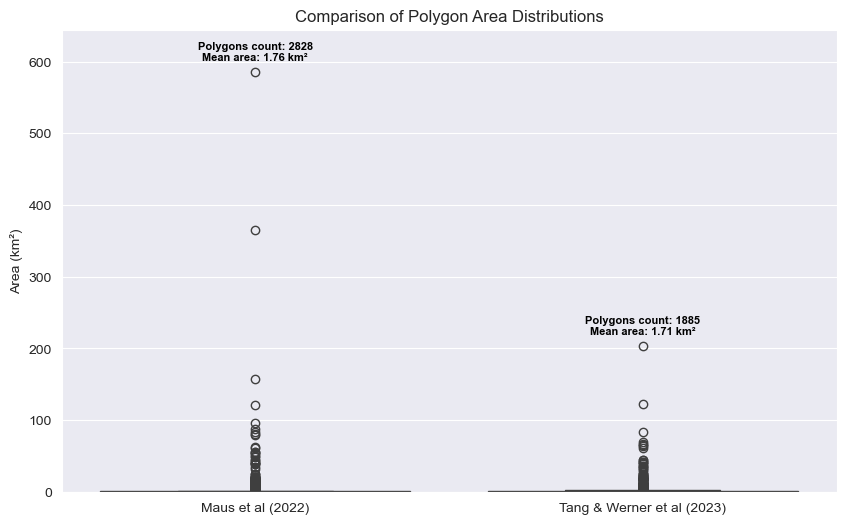

,Dataset,Polygon Count,Min Area (km²),Mean Area (km²),Median Area (km²),Max Area (km²)
0,Maus et al (2022),2828,0.000353,1.756474,0.150263,585.820363
1,Tang & Werner et al (2023),1885,0.001375,1.709219,0.212094,203.353532


In [115]:
polygons_areas = analyze_and_compare_polygon_areas(maus_canada_gdf, 
                                  tang_canada_gdf,
                                  'Maus et al (2022)', 
                                  'Tang & Werner et al (2023)',
                                  save_path=r'results/maus_tang_comparison_polygons.png'
                                  )
polygons_areas


### Create indigenous table

In [267]:
indigenous_gdf = gpd.read_file(r'data/Sources/Indigenous_lands/Indigenous_comm_lands_v202411/Indigenous_comm_lands_v202411/CommunityLevelData_poly_202411.shp')
indigenous_can_gdf = indigenous_gdf[indigenous_gdf['Country'] == 'Canada']

In [269]:
col_to_keep = ['Name', 'Category', 'Data_Src', 'Data_Date', 'geometry']
indigenous_can_gdf = indigenous_can_gdf[col_to_keep] 

In [273]:
# Simplify geometries while keeping essential shape 
tolerance = 100  # 100 meters simplification tolerance
indigenous_can_gdf["geometry"] = indigenous_can_gdf["geometry"].apply(lambda geom: geom.simplify(tolerance, preserve_topology=True))
# Fix invalid geometries after simplification
indigenous_can_gdf["geometry"] = indigenous_can_gdf["geometry"].buffer(0)

C:\Users\mp_ma\anaconda3\envs\gis\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [274]:
indigenous_can_gdf = assign_id(
    indigenous_can_gdf,
    canada_provinces,
    id_column = "indigenous_land_id",
    prefix='IND',
    name_col='Name'
)

C:\Users\mp_ma\anaconda3\envs\gis\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\mp_ma\anaconda3\envs\gis\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\mp_ma\anaconda3\envs\gis\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [275]:
indigenous_can_gdf

,indigenous_land_id,Name,Category,Data_Src,Data_Date,geometry,longitude,latitude
2864,ZZ-IND-6b5615ab,Nicola Lake 1,Indian Reserve,"Natural Resources Canada, Earth Sciences Secto...",2012/09/05,MULTIPOLYGON Z (((-13412001.078 6484020.720 0....,-1.340968e+07,6.482531e+06
2865,ZZ-IND-b4a52700,Piikani Reserve,Indian Reserve,"Natural Resources Canada, Earth Sciences Secto...",2012/09/05,MULTIPOLYGON Z (((-12638644.679 6375535.364 0....,-1.265128e+07,6.375073e+06
2866,ZZ-IND-cf5cc3a8,Suwannee Lake Indian Reserve 09924,Indian Reserve,"Natural Resources Canada, Earth Sciences Secto...",2013/05/30,"POLYGON Z ((-11149110.724 7581557.313 0.000, -...",-1.114723e+07,7.586468e+06
2867,ZZ-IND-d4241875,Chitek Lake I.r. 191,Indian Reserve,"Natural Resources Canada, Earth Sciences Secto...",2013/09/09,MULTIPOLYGON Z (((-11991380.215 7116416.576 0....,-1.199724e+07,7.113774e+06
2868,ZZ-IND-d7814823,Couchiching Indian Reserve No. 16a,Indian Reserve,"Natural Resources Canada, Earth Sciences Secto...",2013/09/09,MULTIPOLYGON Z (((-10398281.993 6223676.777 0....,-1.040011e+07,6.221741e+06
...,...,...,...,...,...,...,...,...
53214,ZZ-IND-4f40d0e2,Maa-nulth,First Nations Treaty Lands,Ministry of Aboriginal Relations and Reconcili...,2016/06/09,MULTIPOLYGON Z (((-13935109.163 6271300.023 0....,-1.393596e+07,6.271405e+06
53215,ZZ-IND-bd86f255,Maa-nulth,First Nations Treaty Lands,Ministry of Aboriginal Relations and Reconcili...,2016/06/09,MULTIPOLYGON Z (((-13915849.512 6301673.475 0....,-1.391665e+07,6.302836e+06
53216,ZZ-IND-1748b6ed,Maa-nulth,First Nations Treaty Lands,Ministry of Aboriginal Relations and Reconcili...,2016/06/09,MULTIPOLYGON Z (((-13900991.756 6286092.967 0....,-1.390818e+07,6.289651e+06
53217,ZZ-IND-a914af3f,Maa-nulth,First Nations Treaty Lands,Ministry of Aboriginal Relations and Reconcili...,2016/06/09,MULTIPOLYGON Z (((-13981167.298 6267857.450 0....,-1.398181e+07,6.269168e+06


### Create protected areas table

In [122]:
# Polygons
wpda_gdf_polygons_1 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_0\WDPA_WDOECM_Mar2025_Public_CAN_shp-polygons.shp')
wpda_gdf_polygons_2 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_1\WDPA_WDOECM_Mar2025_Public_CAN_shp-polygons.shp')
wpda_gdf_polygons_3 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_2\WDPA_WDOECM_Mar2025_Public_CAN_shp-polygons.shp')

# Points
wpda_gdf_points_1 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_0\WDPA_WDOECM_Mar2025_Public_CAN_shp-points.shp')
wpda_gdf_points_2 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_1\WDPA_WDOECM_Mar2025_Public_CAN_shp-points.shp')
wpda_gdf_points_3 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_2\WDPA_WDOECM_Mar2025_Public_CAN_shp-points.shp')

In [123]:
# We merge the 3 files together
wpda_gdf_polygons = gpd.GeoDataFrame(pd.concat([
    wpda_gdf_polygons_1, wpda_gdf_polygons_2, wpda_gdf_polygons_3], 
    ignore_index=True))

wpda_gdf_points = gpd.GeoDataFrame(pd.concat([
    wpda_gdf_points_1, wpda_gdf_points_2, wpda_gdf_points_3], 
    ignore_index=True))

In [124]:
# Convert MULTIPOINT geometries to POINT
def multipoint_to_point(geom):
    """Extracts the first point from a MULTIPOINT."""
    if geom.geom_type == "MultiPoint":
        return geom.geoms[0]  # Extract first point
    return geom  # Return as-is if it's already a Point

In [125]:
wpda_gdf_points["geometry"] = wpda_gdf_points["geometry"].apply(multipoint_to_point)

In [126]:
col_to_keep = ['NAME', 'DESIG', 'OWN_TYPE', 'MANG_AUTH', 'STATUS_YR', 'geometry']
wpda_gdf_polygons = wpda_gdf_polygons[col_to_keep]
wpda_gdf_points = wpda_gdf_points[col_to_keep]

In [127]:
# Simplify geometries while keeping essential shape 
tolerance = 100  # 100 meters simplification tolerance
wpda_gdf_polygons["geometry"] = wpda_gdf_polygons["geometry"].apply(lambda geom: geom.simplify(tolerance, preserve_topology=True))
# Fix invalid geometries after simplification
wpda_gdf_polygons["geometry"] = wpda_gdf_polygons["geometry"].buffer(0)

In [128]:
wpda_gdf_polygons = assign_id(
    wpda_gdf_polygons,
    canada_provinces,
    id_column = "wpda_id",
    prefix='WPDA', 
    name_col='NAME'
)

In [129]:
wpda_gdf_points = assign_id(
    wpda_gdf_points,
    canada_provinces,
    id_column = "wpda_id",
    prefix='WPDA',
    name_col='NAME'
)

In [130]:
wpda_gdf_polygons

,wpda_id,NAME,DESIG,OWN_TYPE,MANG_AUTH,STATUS_YR,geometry,longitude,latitude
0,AB-WPDA-7617a1f2,Wood Buffalo National Park Of Canada,National Park,State,Parks Canada Agency,1922,"POLYGON ((-112.87253 59.99877, -111.53006 59.7...",-112.773975,59.185652
1,NT-WPDA-f99b62d0,Wood Buffalo National Park Of Canada,National Park,State,Parks Canada Agency,1922,"POLYGON ((-112.87253 59.99877, -115.58450 59.9...",-114.178396,60.292670
2,YT-WPDA-75b555cc,Kluane National Park Reserve Of Canada,National Park,State,Parks Canada Agency,1972,"POLYGON ((-141.00187 60.30634, -137.43466 60.7...",-138.484647,60.441679
3,NU-WPDA-c31a7f0a,Auyuittuq National Park Of Canada,National Park,State,Parks Canada Agency,1972,"MULTIPOLYGON (((-64.62292 67.13706, -63.92605 ...",-65.338483,67.527728
4,NU-WPDA-b6c6ec6a,Auyuittuq National Park Of Canada,National Park,State,Parks Canada Agency,1972,"MULTIPOLYGON (((-68.23194 67.76712, -67.56846 ...",-66.227786,67.296073
...,...,...,...,...,...,...,...,...,...
13463,QC-WPDA-f605adfb,Grosse Île and the Irish Memorial National His...,Lieu historique national,State,Parks Canada Agency,2023,"MULTIPOLYGON (((-70.67843 47.01639, -70.67802 ...",-70.670945,47.028516
13464,ON-WPDA-1f683d24,Navy Island National Historic Site,National Historic Site,State,Parks Canada Agency,2023,"POLYGON ((-79.01037 43.04900, -79.00871 43.060...",-79.007646,43.054687
13465,ON-WPDA-f0dabdeb,Fort George National Historic Site (Paradise G...,National Historic Site,State,Parks Canada Agency,2023,"POLYGON ((-79.06782 43.24368, -79.05901 43.248...",-79.062638,43.244583
13466,ON-WPDA-427f2f84,Rideau Canal National Historic Site,National Historic Site,State,Parks Canada Agency,2023,"MULTIPOLYGON (((-76.24341 44.90190, -76.19385 ...",-76.082979,44.766100


In [131]:
wpda_gdf_points

,wpda_id,NAME,DESIG,OWN_TYPE,MANG_AUTH,STATUS_YR,geometry,longitude,latitude
0,ZZ-WPDA-a5cb4014,Tabusintac Lagoon and River Estuary,"Ramsar Site, Wetland of International Importance",Not Reported,Not Reported,1993,POINT (-64.93333 47.33333),-64.933333,47.333333
1,ON-WPDA-c30da438,Minesing Swamp,"Ramsar Site, Wetland of International Importance",Not Reported,Not Reported,1996,POINT (-80.86667 44.38333),-80.866667,44.383333
2,ON-WPDA-7ec5b2fe,Matchedash Bay,"Ramsar Site, Wetland of International Importance",Not Reported,Not Reported,1996,POINT (-79.66667 44.73333),-79.666667,44.733333
3,QC-WPDA-23020864,Lac Saint Pierre,"Ramsar Site, Wetland of International Importance",Not Reported,Not Reported,1998,POINT (-72.65000 46.13333),-72.650000,46.133333
4,AB-WPDA-84789957,Columbia Wetlands,"Ramsar Site, Wetland of International Importance",Not Reported,Not Reported,2005,POINT (-115.21667 50.68333),-115.216667,50.683333
5,ON-WPDA-a9a5ef05,Mont Saint Hilaire,UNESCO-MAB Biosphere Reserve,Not Reported,Not Reported,1978,POINT (-75.16667 45.55000),-75.166667,45.550000
6,MB-WPDA-1e5f495f,Riding Mountain Biosphere Reserve,UNESCO-MAB Biosphere Reserve,Not Reported,Not Reported,1986,POINT (-100.30000 50.76670),-100.300000,50.766700
7,ON-WPDA-d378cfea,Long Point Biosphere Reserve,UNESCO-MAB Biosphere Reserve,Not Reported,Not Reported,1986,POINT (-80.33000 43.58000),-80.330000,43.580000
8,QC-WPDA-b8835fe2,Réserve de la biosphère de Charlevoix,UNESCO-MAB Biosphere Reserve,Not Reported,Not Reported,1988,POINT (-70.55000 47.66667),-70.550000,47.666667
9,ON-WPDA-cbab9fbd,Niagara Escarpment Biosphere Reserve,UNESCO-MAB Biosphere Reserve,Not Reported,Not Reported,1990,POINT (-79.93000 43.62000),-79.930000,43.620000


# 2) Matching

In [134]:
from matching_functions import match_facilities, filter_matches, one_to_many_relationships, match_facility_to_polygons_with_buffer
from matching_functions import cluster_sites_and_polygons

In [135]:
def one_to_many_relationships(
    match_df,
    id_main_col,
    id_sat_col,
    distance_threshold_m=2000,
    similarity_threshold=80,
    similarity_metric="token_set"  # "partial" or "token_set"
):
    """
    Give me the single best match for each satellite entry — only if it passes the thresholds.

    Parameters:
        match_df (pd.DataFrame): Output from match_facilities().
        id_main_col (str): ID column for the main facilities table.
        id_sat_col (str): ID column for the satellite table.
        distance_threshold_m (float): Max distance in meters.
        similarity_threshold (float): Min similarity score (0–100).
        similarity_metric (str): 'partial' or 'token_set'.

    Returns:
        pd.DataFrame: Best matches [id_sat_col, id_main_col] or NaN if no good match found.
    """
    df = match_df.dropna(subset=[id_main_col, id_sat_col]).copy()

    # Select the similarity column
    sim_col = {
        "partial": "similarity_partial_score",
        "token_set": "similarity_token_set"
    }.get(similarity_metric, "similarity_token_set")

    # Apply threshold filtering
    df = df[
        (df["distance_m"] <= distance_threshold_m) &
        (df[sim_col] >= similarity_threshold)
    ]

    # Pick the best match per satellite ID
    df["score"] = df[sim_col] + (1 / (1 + df["distance_m"]))
    df = df.sort_values("score", ascending=False).drop_duplicates(subset=[id_sat_col])

    return df[[id_sat_col, id_main_col]]


def filter_matches(
    match_df,
    distance_threshold_m=None,
    similarity_threshold=None,
    similarity_metric="token_set",  # or "partial"
    strategy="and"
):
    """
    Give me all matches that meet the thresholds..

    Parameters:
        match_df (pd.DataFrame): Output from match_facilities().
        distance_threshold_m (float or None): Max distance allowed.
        similarity_threshold (float or None): Min similarity score allowed (0–100).
        similarity_metric (str): 'partial' or 'token_set'.
        strategy (str): 'and' (both conditions) or 'or' (either passes).

    Returns:
        pd.DataFrame: Filtered match candidates.
    """
    df = match_df.copy()

    sim_col = {
        "partial": "similarity_partial_score",
        "token_set": "similarity_token_set"
    }.get(similarity_metric, "similarity_token_set")

    conditions = []
    if distance_threshold_m is not None:
        conditions.append(df["distance_m"] <= distance_threshold_m)
    if similarity_threshold is not None:
        conditions.append(df[sim_col] >= similarity_threshold)

    if conditions:
        if strategy == "and":
            combined = conditions[0]
            for cond in conditions[1:]:
                combined &= cond
        elif strategy == "or":
            combined = conditions[0]
            for cond in conditions[1:]:
                combined |= cond
        else:
            raise ValueError("strategy must be 'and' or 'or'")
        df = df[combined]

    return df.reset_index(drop=True)


## Point to point matching

### MinCan

Some mines in MinCan dataset have very slightly different name (e.g. LaRonde - Zone 5 and LaRonde), or several companies for the same mines.

In [300]:
lt_main_mincan = match_facilities(main_gdf, min_can_gdf,
                     id_col1='main_id', id_col2='mincan_id',
                     name_col1='facility_name', name_col2='namemine'
                     )

In [301]:
matches_main_mincan = one_to_many_relationships(
    lt_main_mincan,
    id_main_col='main_id',
    id_sat_col='mincan_id',
    distance_threshold_m=2000,
    similarity_threshold=80,
    similarity_metric="token_set"  # "partial" or "token_set"
)

In [302]:
min_can_gdf = min_can_gdf.merge(
    matches_main_mincan,
    on="mincan_id",  # join using the GHG table's ID
    how="left"
)

### Tailings

In [139]:
lt_main_tailings = match_facilities(main_gdf, tailings_gdf,
                     id_col1='main_id', id_col2='tailing_id',
                     name_col1='facility_name', name_col2='related_mine'
                     )

In [140]:
matches_main_tailings = one_to_many_relationships(
    lt_main_tailings,
    id_main_col='main_id',
    id_sat_col='tailing_id',
    distance_threshold_m=20000,
    similarity_threshold=80,
    similarity_metric="token_set"  # "partial" or "token_set"
)

In [141]:
tailings_gdf = tailings_gdf.merge(
    matches_main_tailings,
    on="tailing_id",  # join using the GHG table's ID
    how="left"
)

In [142]:
tailings_gdf 

,row_id,year,tailing_id,tsf_name,related_mine,main_owner,full_ownership,operator,longitude,latitude,...,current_maximum_height,current_tailings_storage,planned_storage_5_years,hazard_categorization,classification_system,link,source,source_df,geometry,main_id
0,TAIL-ce1b28f4-2019-1,2019,NU-TAIL-ce1b28f4,North Cell,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.043328,65.021558,...,31.0,14400000,14400000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,tailings_source_df,POINT (-96.04333 65.02156),NU-MAIN-730aefe3
1,TAIL-46b364c0-2019-1,2019,NU-TAIL-46b364c0,South Cell,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.033391,65.013782,...,49.0,10420000,10800000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,tailings_source_df,POINT (-96.03339 65.01378),NU-MAIN-730aefe3
2,TAIL-6612fa3a-2019-1,2019,NU-TAIL-6612fa3a,In pit,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.032544,65.001901,...,NaN,850000,12500000,Low,NaN,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,tailings_source_df,POINT (-96.03254 65.00190),NU-MAIN-730aefe3
3,TAIL-f33b3dac-2019-1,2019,NU-TAIL-f33b3dac,Meliadine TSF,Meliadine,Agnico Eagle,NaN,Agnico Eagle,-92.140336,63.020829,...,5.0,89000,4354000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,tailings_source_df,POINT (-92.14034 63.02083),NU-MAIN-8b0264c9
4,TAIL-bb8684fa-2019-1,2019,QC-TAIL-bb8684fa,South TSF,Goldex,Agnico Eagle,NaN,Agnico Eagle,-77.841978,48.054342,...,5.0,1664000,2500000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,tailings_source_df,POINT (-77.84198 48.05434),QC-MAIN-c0660aec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,TAIL-547aba47-2019-1,2019,BC-TAIL-547aba47,TMA,Equity Silver,Newmont Goldcorp,NaN,Newmont/Goldcorp,-126.269100,54.204300,...,61.0,48000000,NaN,Very High,Canadian Dam Association,https://www.newmontgoldcorp.com/document/churc...,NaN,tailings_source_df,POINT (-126.26910 54.20430),NaN
223,TAIL-7791ece7-2019-1,2019,NT-TAIL-7791ece7,Upper Pud,Miramar - Con Mine,Newmont Goldcorp,NaN,Miramar,-114.376300,62.430800,...,13.0,1550000,NaN,Low,Canadian Dam Association,https://www.newmontgoldcorp.com/document/churc...,NaN,tailings_source_df,POINT (-114.37630 62.43080),NaN
224,TAIL-c0247868-2019-1,2019,NT-TAIL-c0247868,Middle Pud,Miramar - Con Mine,Newmont Goldcorp,NaN,Miramar,-114.376300,62.430800,...,7.0,930000,NaN,Low,Canadian Dam Association,https://www.newmontgoldcorp.com/document/churc...,NaN,tailings_source_df,POINT (-114.37630 62.43080),NaN
225,TAIL-fee10612-2019-1,2019,NT-TAIL-fee10612,"Lower Pud, Neil Lake and Neques TCAs",Miramar - Con Mine,Newmont Goldcorp,NaN,Miramar,-114.376300,62.430800,...,1.5,620000,NaN,Low,Canadian Dam Association,https://www.newmontgoldcorp.com/document/churc...,NaN,tailings_source_df,POINT (-114.37630 62.43080),NaN


### GHG

In [143]:
lt_main_ghg = match_facilities(main_gdf, ghg_gdf,
                     id_col1='main_id', id_col2='ghg_id',
                     name_col1='facility_name', name_col2='facility_name_ghg'
                     )

In [144]:
matches_main_ghg = one_to_many_relationships(
    lt_main_ghg,
    id_main_col='main_id',
    id_sat_col='ghg_id',
    distance_threshold_m=10000,
    similarity_threshold=80,
    similarity_metric="token_set"  # "partial" or "token_set"
)

In [145]:
ghg_gdf = ghg_gdf.merge(
    matches_main_ghg,
    on="ghg_id",  # join using the GHG table's ID
    how="left"
)

### Pollution

In [146]:
pollutant_gdf

,row_id,year,pollutant_id,facility_name_npri,company_name_npri,facility_type,longitude,latitude,terrestrial_ecozone,watershed,substance_name_npri,substance_name_ecoinvent,substance_unit,emission_type,emission_subtype,value,source_df,geometry
0,POL-0edcc441-2023-1,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Ammonia (total),Ammonia,tonnes,Air Emissions / Émissions à l'air,Stack Emissions,0.636,npri_metal_mining_df,POINT (-80.08734 48.13032)
1,POL-0edcc441-2023-2,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Arsenic (and its compounds),Arsenic,kg,Air Emissions / Émissions à l'air,Stack Emissions,0.116,npri_metal_mining_df,POINT (-80.08734 48.13032)
2,POL-0edcc441-2023-3,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Carbon monoxide,"Carbon monoxide, fossil",tonnes,Air Emissions / Émissions à l'air,Stack Emissions,76.208,npri_metal_mining_df,POINT (-80.08734 48.13032)
3,POL-0edcc441-2023-4,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Chromium (and its compounds),Chromium,tonnes,Air Emissions / Émissions à l'air,Stack Emissions,0.00105,npri_metal_mining_df,POINT (-80.08734 48.13032)
4,POL-0edcc441-2023-5,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Cobalt (and its compounds),Cobalt,kg,Air Emissions / Émissions à l'air,Stack Emissions,0.18,npri_metal_mining_df,POINT (-80.08734 48.13032)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24125,POL-babe230e-2023-6,2023,ON-pollutant-babe230e,Rayette Manufacturing,NaN,manufacturing,-79.49600,43.80800,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",25.1008,npri_metal_manufacturing_df,POINT (-79.49600 43.80800)
24126,POL-fcf964d1-2023-6,2023,ON-pollutant-fcf964d1,Bowes Manufacturing,NaN,manufacturing,-79.49480,43.80360,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",23.418,npri_metal_manufacturing_df,POINT (-79.49480 43.80360)
24127,POL-c69ac49d-2023-2,2023,ON-pollutant-c69ac49d,541 Bowes Warehouse,NaN,manufacturing,-79.49707,43.81726,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",16.543746,npri_metal_manufacturing_df,POINT (-79.49707 43.81726)
24128,POL-babe230e-2023-7,2023,ON-pollutant-babe230e,Rayette Manufacturing,NaN,manufacturing,-79.49600,43.80800,Mixedwood Plain,St. Lawrence Drainage Area,Volatile Organic Compounds (Total),NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",12.5823,npri_metal_manufacturing_df,POINT (-79.49600 43.80800)


In [147]:
lt_main_pollution = match_facilities(main_gdf, pollutant_gdf,
                     id_col1='main_id', id_col2='pollutant_id',
                     name_col1='facility_name', name_col2='facility_name_npri'
                     )

In [148]:
matches_main_pollution = one_to_many_relationships(
    lt_main_pollution,
    id_main_col='main_id',
    id_sat_col='pollutant_id',
    distance_threshold_m=10000,
    similarity_threshold=80,
    similarity_metric="token_set"  # "partial" or "token_set"
)

In [149]:
pollutant_gdf = pollutant_gdf.merge(
    matches_main_pollution,
    on="pollutant_id",  # join using the GHG table's ID
    how="left"
)

In [150]:
pollutant_gdf

,row_id,year,pollutant_id,facility_name_npri,company_name_npri,facility_type,longitude,latitude,terrestrial_ecozone,watershed,substance_name_npri,substance_name_ecoinvent,substance_unit,emission_type,emission_subtype,value,source_df,geometry,main_id
0,POL-0edcc441-2023-1,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Ammonia (total),Ammonia,tonnes,Air Emissions / Émissions à l'air,Stack Emissions,0.636,npri_metal_mining_df,POINT (-80.08734 48.13032),ON-MAIN-1f126a43
1,POL-0edcc441-2023-2,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Arsenic (and its compounds),Arsenic,kg,Air Emissions / Émissions à l'air,Stack Emissions,0.116,npri_metal_mining_df,POINT (-80.08734 48.13032),ON-MAIN-1f126a43
2,POL-0edcc441-2023-3,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Carbon monoxide,"Carbon monoxide, fossil",tonnes,Air Emissions / Émissions à l'air,Stack Emissions,76.208,npri_metal_mining_df,POINT (-80.08734 48.13032),ON-MAIN-1f126a43
3,POL-0edcc441-2023-4,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Chromium (and its compounds),Chromium,tonnes,Air Emissions / Émissions à l'air,Stack Emissions,0.00105,npri_metal_mining_df,POINT (-80.08734 48.13032),ON-MAIN-1f126a43
4,POL-0edcc441-2023-5,2023,ON-pollutant-0edcc441,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Cobalt (and its compounds),Cobalt,kg,Air Emissions / Émissions à l'air,Stack Emissions,0.18,npri_metal_mining_df,POINT (-80.08734 48.13032),ON-MAIN-1f126a43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24125,POL-babe230e-2023-6,2023,ON-pollutant-babe230e,Rayette Manufacturing,NaN,manufacturing,-79.49600,43.80800,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",25.1008,npri_metal_manufacturing_df,POINT (-79.49600 43.80800),NaN
24126,POL-fcf964d1-2023-6,2023,ON-pollutant-fcf964d1,Bowes Manufacturing,NaN,manufacturing,-79.49480,43.80360,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",23.418,npri_metal_manufacturing_df,POINT (-79.49480 43.80360),NaN
24127,POL-c69ac49d-2023-2,2023,ON-pollutant-c69ac49d,541 Bowes Warehouse,NaN,manufacturing,-79.49707,43.81726,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",16.543746,npri_metal_manufacturing_df,POINT (-79.49707 43.81726),NaN
24128,POL-babe230e-2023-7,2023,ON-pollutant-babe230e,Rayette Manufacturing,NaN,manufacturing,-79.49600,43.80800,Mixedwood Plain,St. Lawrence Drainage Area,Volatile Organic Compounds (Total),NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",12.5823,npri_metal_manufacturing_df,POINT (-79.49600 43.80800),NaN


## Point to polygon matching

### Buffer approach

Many-to-many relationships so we keep only the matching tables.

In [225]:
matching_main_wpda = match_facility_to_polygons_with_buffer(main_gdf, wpda_gdf_polygons, 'main_id', 'wpda_id', buffer_km=50)

In [227]:
matching_main_wpda = matching_main_wpda.dropna(subset=["distance_to_centroid_m"])
matching_main_wpda

,main_id,wpda_id,distance_to_centroid_m,distance_to_edge_m
0,NL-MAIN-251d6364,NL-WPDA-f70b7186,69486.07,39197.65
1,NL-MAIN-251d6364,NL-WPDA-af652f7d,45226.72,44817.42
2,NL-MAIN-842ba1b4,NL-WPDA-3c470c4e,39855.02,39408.78
3,NL-MAIN-842ba1b4,ZZ-WPDA-32cdf68a,44668.00,44409.66
4,NL-MAIN-842ba1b4,ZZ-WPDA-bd0a29ef,47818.76,47182.10
...,...,...,...,...
11499,QC-MAIN-715d4318,QC-WPDA-39eab1be,49782.59,49737.37
11500,QC-MAIN-715d4318,QC-WPDA-40bf7ff8,47381.65,47077.55
11501,QC-MAIN-715d4318,QC-WPDA-1626d7c8,48368.52,47856.22
11502,QC-MAIN-715d4318,QC-WPDA-7a537e0a,15055.03,14446.30


In [276]:
matching_main_indigenous = match_facility_to_polygons_with_buffer(main_gdf, indigenous_can_gdf, 'main_id', 'indigenous_land_id', buffer_km=50)

In [277]:
matching_main_indigenous = matching_main_indigenous.dropna(subset=["distance_to_centroid_m"])
matching_main_indigenous

,main_id,indigenous_land_id,distance_to_centroid_m,distance_to_edge_m
7,NL-MAIN-e09881ff,ZZ-IND-b3b69158,20698.52,20320.83
8,NL-MAIN-e09881ff,ZZ-IND-97d4f914,19157.02,18288.34
9,NL-MAIN-e09881ff,ZZ-IND-ee62704a,17924.97,13361.21
10,NS-MAIN-c9c77a59,ZZ-IND-3a92cd39,46826.81,46653.49
11,NS-MAIN-c9c77a59,ZZ-IND-f41013f4,47387.34,47106.98
...,...,...,...,...
1315,NB-MAIN-0c5b40d8,ZZ-IND-45d45423,52716.19,46227.75
1317,NB-MAIN-8e04eb21,ZZ-IND-878a8cc7,24129.79,22959.20
1318,QC-MAIN-5801b453,ZZ-IND-a8bafff3,33822.13,32971.45
1319,QC-MAIN-715d4318,ZZ-IND-8b93e780,27806.34,22155.90


### Clustering approach

In [234]:
# Fix the geometries, some are Point (nan, nan)
tailings_gdf = tailings_gdf[
    (tailings_gdf.geometry.notnull()) &
    (~tailings_gdf.geometry.is_empty) &
    (tailings_gdf.geometry.type == "Point") &
    (~tailings_gdf.geometry.apply(lambda g: np.isnan(g.x) or np.isnan(g.y)))
].copy()

In [235]:
def clustering_dbcan(
    facility_gdf, polygon_gdf, tailing_gdf,
    facility_id_col="main_id",
    polygon_id_col="tang_id",
    tailing_id_col="tailing_id",
    eps_km=10, min_samples=2, crs="EPSG:3978", boundary_step=5
):
    """
    Cluster facilities, tailings, and polygon boundaries using DBSCAN.

    Returns:
    - facility_gdf, tailing_gdf, polygon_gdf: each with one cluster_id per entity (replacing -1 with "No cluster")
    - cluster_link_df: tidy table of (main_id, tailing_id, tang_id, cluster_id, check_manually)
    """

    import pandas as pd
    import numpy as np
    import geopandas as gpd
    from shapely.geometry import Point, Polygon, MultiPolygon
    from shapely.ops import transform
    from sklearn.cluster import DBSCAN

    # Preserve original polygon_gdf
    polygon_gdf_original = polygon_gdf.copy()

    # Project all layers
    facility_gdf = facility_gdf.to_crs(crs)
    tailing_gdf = tailing_gdf.to_crs(crs)
    polygon_gdf_proj = polygon_gdf.to_crs(crs).explode(index_parts=False).reset_index(drop=True)

    # Clean Z-dimension from polygon geometries
    def to_2d(geom):
        if isinstance(geom, MultiPolygon):
            return MultiPolygon([Polygon([(x, y) for x, y, *_ in poly.exterior.coords]) for poly in geom.geoms])
        elif isinstance(geom, Polygon):
            return Polygon([(x, y) for x, y, *_ in geom.exterior.coords])
        return geom

    polygon_gdf_proj["geometry"] = polygon_gdf_proj["geometry"].apply(to_2d)

    # Sample polygon boundary points
    def boundary_points(geom, pid):
        coords = list(geom.exterior.coords)[::boundary_step]
        return [(pid, Point(c)) for c in coords]

    poly_points = []
    for _, row in polygon_gdf_proj.iterrows():
        poly_points.extend(boundary_points(row["geometry"], row[polygon_id_col]))

    poly_gdf = gpd.GeoDataFrame(poly_points, columns=[polygon_id_col, "geometry"], crs=crs)
    poly_gdf[facility_id_col] = None
    poly_gdf[tailing_id_col] = None

    # Prepare facility and tailing points
    facility_tmp = facility_gdf[[facility_id_col, "geometry"]].copy()
    facility_tmp[polygon_id_col] = None
    facility_tmp[tailing_id_col] = None

    tailing_tmp = tailing_gdf[[tailing_id_col, "geometry"]].copy()
    tailing_tmp[polygon_id_col] = None
    tailing_tmp[facility_id_col] = None

    # Combine all points
    all_points = pd.concat([facility_tmp, tailing_tmp, poly_gdf], ignore_index=True)
    all_points = all_points[all_points.geometry.notna()].copy()

    # Apply DBSCAN clustering
    coords = np.array([(geom.x, geom.y) for geom in all_points.geometry])
    db = DBSCAN(eps=eps_km * 1000, min_samples=min_samples).fit(coords)
    all_points["cluster_id"] = db.labels_

    # Extract one cluster_id per unique entity
    def extract_entity_clusters(col_name):
        return (
            all_points[[col_name, "cluster_id"]]
            .dropna(subset=[col_name])
            .drop_duplicates(subset=[col_name])
        )

    facility_clusters = extract_entity_clusters(facility_id_col)
    tailing_clusters = extract_entity_clusters(tailing_id_col)
    polygon_clusters = extract_entity_clusters(polygon_id_col)

    # Merge cluster_id into original GeoDataFrames
    facility_gdf = facility_gdf.merge(facility_clusters, on=facility_id_col, how="left")
    tailing_gdf = tailing_gdf.merge(tailing_clusters, on=tailing_id_col, how="left")
    polygon_gdf = polygon_gdf_original.merge(polygon_clusters, on=polygon_id_col, how="left")

    # Replace cluster_id = -1 with "No cluster"
    for gdf in (facility_gdf, polygon_gdf, tailing_gdf):
        if "cluster_id" in gdf.columns:
            gdf["cluster_id"] = gdf["cluster_id"].fillna(-1).replace(-1, "No cluster")

    # Replace -1 with "No cluster" in all_points for consistency
    all_points["cluster_id"] = all_points["cluster_id"].fillna(-1).replace(-1, "No cluster")

    # Count #facilities and #tailings per cluster
    cluster_stats = all_points.groupby("cluster_id").agg({
        facility_id_col: lambda x: x.notna().sum(),
        tailing_id_col: lambda x: x.notna().sum()
    }).rename(columns={
        facility_id_col: "n_facilities",
        tailing_id_col: "n_tailings"
    }).reset_index()

    cluster_stats["check_manually"] = (cluster_stats["n_facilities"] > 1) | (cluster_stats["n_tailings"] > 1)

    # Create cluster link table: one row per entity with cluster_id
    cluster_link_df = all_points[
        [facility_id_col, tailing_id_col, polygon_id_col, "cluster_id"]
    ].dropna(subset=["cluster_id"]).copy()

    cluster_link_df = (
        pd.concat([
            cluster_link_df[[facility_id_col, "cluster_id"]].dropna().drop_duplicates(),
            cluster_link_df[[tailing_id_col, "cluster_id"]].dropna().drop_duplicates(),
            cluster_link_df[[polygon_id_col, "cluster_id"]].dropna().drop_duplicates()
        ])
        .reset_index(drop=True)
    )

    # Merge check_manually flag into cluster_link_df
    cluster_link_df = cluster_link_df.merge(cluster_stats[["cluster_id", "check_manually"]], on="cluster_id", how="left")

    # Final tidy output
    return facility_gdf, polygon_gdf, tailing_gdf, cluster_link_df


In [236]:
main_gdf_copy, tang_canada_gdf_copy, tailings_gdf_copy, lt_land_occupation = clustering_dbcan(main_gdf, tang_canada_gdf, tailings_gdf)

# 3) Exports 

## Simple format

In [ ]:
from db_creation_function import export_sqlite_db

In [278]:
import sqlite3
import os

def export_sqlite_db(db_path, tables_dict, keep_geometry_tables=None, csv_dir=None):
    """
    Export multiple (Geo)DataFrames to both SQLite and CSV with optional geometry as WKT.

    Parameters:
        db_path (str): Path to SQLite database file.
        tables_dict (dict): {table_name: DataFrame or GeoDataFrame}.
        keep_geometry_tables (list): List of table names to keep geometry (as WKT).
        csv_dir (str, optional): Directory to export CSV files (default: same as db_path).
    """
    if keep_geometry_tables is None:
        keep_geometry_tables = []

    # Get folder for CSVs
    if csv_dir is None:
        csv_dir = os.path.dirname(db_path)

    os.makedirs(csv_dir, exist_ok=True)

    # Connect to SQLite
    conn = sqlite3.connect(db_path)

    for table_name, df in tables_dict.items():
        df_export = df.copy()

        # Handle geometry
        if "geometry" in df_export.columns:
            if table_name in keep_geometry_tables:
                df_export["geometry"] = df_export.geometry.to_wkt()
            else:
                df_export = df_export.drop(columns="geometry")

        # Export to SQLite
        df_export.to_sql(table_name, conn, if_exists="replace", index=False)

        # Export to CSV
        csv_path = os.path.join(csv_dir, f"{table_name}.csv")
        df_export.to_csv(csv_path, index=False)

        print(f"✅ Exported '{table_name}' → SQLite + CSV")

    conn.close()
    print(f"✅ All exports completed to SQLite and CSVs in: {csv_dir}")


In [279]:
export_sqlite_db(
    "data/Tables/metallican.sqlite", 
    tables_dict={
    "main": main_gdf_copy,
    "tailings": tailings_gdf_copy,
    "mincan": min_can_gdf,
    "ghg": ghg_gdf,
    "pollution": pollutant_gdf,
    "climate_categories": climate_category_gdf,
    "peatland": peatland_gdf,
    "weather": weather_gdf,
    "population": population_gdf,
    "natural_potential_vegetation": npv_gdf,
    "land_cover": land_cover_gdf,
    "water_risk": water_risk_gdf,
    "land_occupation": tang_canada_gdf_copy,
    "indigenous_land": indigenous_can_gdf,
    "protected_land": wpda_gdf_polygons,
    "lt_protected_land": matching_main_wpda,
    "lt_indigenous_land": matching_main_indigenous,
    "lt_clusters": lt_land_occupation
},
    keep_geometry_tables=['main', 'tailings'], 
    csv_dir='data/Tables/csv'
)

✅ Exported 'main' → SQLite + CSV
✅ Exported 'tailings' → SQLite + CSV
✅ Exported 'mincan' → SQLite + CSV
✅ Exported 'ghg' → SQLite + CSV


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_16788\4261974238.py:32: UserWarning: Geometry column does not contain geometry.
  df_export["geometry"] = df_export.geometry.to_wkt()
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_16788\4261974238.py:32: UserWarning: Geometry column does not contain geometry.
  df_export["geometry"] = df_export.geometry.to_wkt()


✅ Exported 'pollution' → SQLite + CSV
✅ Exported 'climate_categories' → SQLite + CSV
✅ Exported 'peatland' → SQLite + CSV
✅ Exported 'weather' → SQLite + CSV
✅ Exported 'population' → SQLite + CSV
✅ Exported 'natural_potential_vegetation' → SQLite + CSV
✅ Exported 'land_cover' → SQLite + CSV
✅ Exported 'water_risk' → SQLite + CSV
✅ Exported 'land_occupation' → SQLite + CSV
✅ Exported 'indigenous_land' → SQLite + CSV
✅ Exported 'protected_land' → SQLite + CSV
✅ Exported 'lt_protected_land' → SQLite + CSV
✅ Exported 'lt_indigenous_land' → SQLite + CSV
✅ Exported 'lt_clusters' → SQLite + CSV
✅ All exports completed to SQLite and CSVs in: data/Tables/csv


## More advanced setting

In [305]:
import sqlite3
import pandas as pd
import os
import re

def create_and_fill_sqlite(db_path, schema_path, tables_dict, keep_geometry_tables=None):
    """
    Creates an SQLite DB from a schema.sql file and fills it with data from tables_dict.

    Parameters:
        db_path (str): Path to SQLite database.
        schema_path (str): Path to .sql schema file.
        tables_dict (dict): {table_name: pd.DataFrame or gpd.GeoDataFrame}
        keep_geometry_tables (list): Optional list of table names to keep 'geometry' as WKT.
    """
    if keep_geometry_tables is None:
        keep_geometry_tables = []

    # Read schema and auto-insert DROP TABLE IF EXISTS
    with open(schema_path, "r", encoding="utf-8") as f:
        schema = f.read()

    def insert_drops(schema_sql):
        """Adds DROP TABLE IF EXISTS before each CREATE TABLE."""
        return re.sub(
            r'(CREATE TABLE\s+"?([\w_]+)"?\s*\()', 
            lambda m: f'DROP TABLE IF EXISTS "{m.group(2)}";\n{m.group(0)}',
            schema_sql,
            flags=re.IGNORECASE
        )

    schema = insert_drops(schema)

    # Connect and apply schema
    conn = sqlite3.connect(db_path)
    conn.execute("PRAGMA foreign_keys = ON;")
    cursor = conn.cursor()

    # Execute schema statements
    statements = [s.strip() for s in schema.split(';') if s.strip()]
    for stmt in statements:
        cursor.execute(stmt + ";")

    conn.commit()

    # Insert data
    for table_name, df in tables_dict.items():
        df_export = df.copy()

        if "geometry" in df_export.columns:
            if table_name in keep_geometry_tables:
                df_export["geometry"] = df_export.geometry.to_wkt()
            else:
                df_export = df_export.drop(columns="geometry")

        df_export.to_sql(table_name, conn, if_exists="append", index=False)
        print(f"✅ Inserted {len(df_export)} rows into '{table_name}'")

    conn.close()
    print(f"✅ Database created and populated: {db_path}")


In [307]:
invalid_ghg_refs = ghg_gdf[~ghg_gdf["main_id"].isin(main_gdf_copy["main_id"])]
print("Invalid GHG main_ids:\n", invalid_ghg_refs["main_id"].unique())


Invalid GHG main_ids:
 [nan]


In [306]:
create_and_fill_sqlite(
    db_path="data/Tables/metallican_structured.sqlite",
    schema_path="schema.sql",
    tables_dict={
    "main": main_gdf_copy,
    "tailings": tailings_gdf_copy,
    "mincan": min_can_gdf,
    "ghg": ghg_gdf,
    "pollution": pollutant_gdf,
    "climate_categories": climate_category_gdf,
    "peatland": peatland_gdf,
    "weather": weather_gdf,
    "population": population_gdf,
    "natural_potential_vegetation": npv_gdf,
    "land_cover": land_cover_gdf,
    "water_risk": water_risk_gdf,
    "land_occupation": tang_canada_gdf_copy,
    "indigenous_land": indigenous_can_gdf,
    "protected_land": wpda_gdf_polygons,
    "lt_protected_land": matching_main_wpda,
    "lt_indigenous_land": matching_main_indigenous,
    "lt_clusters": lt_land_occupation
},
    keep_geometry_tables=['main', 'tailings']
)

IntegrityError: FOREIGN KEY constraint failed

In [308]:
def validate_foreign_keys(main_df, tables_dict, foreign_key_column="main_id", auto_filter=False):
    """
    Validates that all main_id values in each table exist in the main DataFrame.
    
    Parameters:
        main_df (DataFrame): The main table with valid IDs.
        tables_dict (dict): Dictionary of tables to validate.
        foreign_key_column (str): The foreign key column to check.
        auto_filter (bool): If True, automatically remove invalid rows.
        
    Returns:
        dict: Cleaned tables_dict (if auto_filter=True), else unchanged.
    """
    valid_ids = set(main_df[foreign_key_column].dropna().unique())
    cleaned_tables = {}

    for name, df in tables_dict.items():
        if foreign_key_column in df.columns:
            invalid_rows = df[~df[foreign_key_column].isin(valid_ids)]
            if not invalid_rows.empty:
                print(f"❌ {len(invalid_rows)} invalid '{foreign_key_column}' values in table '{name}':")
                print(invalid_rows[foreign_key_column].drop_duplicates().tolist())
                if auto_filter:
                    df = df[df[foreign_key_column].isin(valid_ids)]
                    print(f"⚠️ Table '{name}' cleaned: {len(df)} valid rows retained.")
            else:
                print(f"✅ Table '{name}': all {foreign_key_column}s are valid.")
        cleaned_tables[name] = df
    return cleaned_tables if auto_filter else tables_dict


In [309]:
cleaned_tables = validate_foreign_keys(
    main_df=main_gdf_copy,
    tables_dict={
        "main": main_gdf_copy,
        "tailings": tailings_gdf_copy,
        "mincan": min_can_gdf,
        "ghg": ghg_gdf,
        "pollution": pollutant_gdf,
        "climate_categories": climate_category_gdf,
        "peatland": peatland_gdf,
        "weather": weather_gdf,
        "population": population_gdf,
        "natural_potential_vegetation": npv_gdf,
        "land_cover": land_cover_gdf,
        "water_risk": water_risk_gdf,
        "land_occupation": tang_canada_gdf_copy,
        "indigenous_land": indigenous_can_gdf,
        "protected_land": wpda_gdf_polygons,
        "lt_protected_land": matching_main_wpda,
        "lt_indigenous_land": matching_main_indigenous,
        "lt_clusters": lt_land_occupation
    },
    auto_filter=True  # ⬅️ Set to False if you only want to diagnose without changing
)


✅ Table 'main': all main_ids are valid.
❌ 124 invalid 'main_id' values in table 'tailings':
[nan]
⚠️ Table 'tailings' cleaned: 98 valid rows retained.
❌ 864 invalid 'main_id' values in table 'mincan':
[nan]
⚠️ Table 'mincan' cleaned: 75 valid rows retained.
❌ 116 invalid 'main_id' values in table 'ghg':
[nan]
⚠️ Table 'ghg' cleaned: 68 valid rows retained.
❌ 10353 invalid 'main_id' values in table 'pollution':
[nan]
⚠️ Table 'pollution' cleaned: 13777 valid rows retained.
✅ Table 'climate_categories': all main_ids are valid.
✅ Table 'peatland': all main_ids are valid.
✅ Table 'weather': all main_ids are valid.
✅ Table 'population': all main_ids are valid.
✅ Table 'natural_potential_vegetation': all main_ids are valid.
✅ Table 'land_cover': all main_ids are valid.
✅ Table 'water_risk': all main_ids are valid.
✅ Table 'lt_protected_land': all main_ids are valid.
✅ Table 'lt_indigenous_land': all main_ids are valid.
❌ 2107 invalid 'main_id' values in table 'lt_clusters':
[nan]
⚠️ Table 'l

## Maps

In [ ]:
from visualization_functions import plot_cluster_map

In [239]:
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import os


def plot_cluster_map(
    facility_gdf,
    tailing_gdf,
    polygon_gdf,
    facility_id_col="main_id",
    tailing_id_col="tailing_id",
    polygon_id_col="tang_id",
    cluster_col="cluster_id",
    output_html="cluster_map.html",
    simplify_tolerance=0.0005,
    open_in_browser=False,
    zoom_start=4,
    center=(56.1304, -106.3468)  # Approximate center of Canada
):
    """
    Creates an interactive map of facilities, tailings, and polygons with cluster IDs in tooltips.

    Parameters:
        facility_gdf, tailing_gdf, polygon_gdf (GeoDataFrames): Input data
        *_id_col (str): ID column name for each type
        cluster_col (str): Shared column storing the cluster label
        output_html (str): Path to output HTML map
        simplify_tolerance (float): Simplify polygon geometries to reduce map size
        open_in_browser (bool): Open the map in a browser after saving
    """

    def _prepare_gdf(gdf, simplify=False):
        gdf = gdf.copy()
        if gdf.crs is None or gdf.crs.to_epsg() != 4326:
            gdf = gdf.to_crs("EPSG:4326")
        if simplify and "geometry" in gdf.columns:
            gdf["geometry"] = gdf.geometry.simplify(simplify_tolerance)
        return gdf[~gdf.geometry.is_empty & gdf.geometry.notna()].reset_index(drop=True)

    # Reproject and simplify as needed
    facility_gdf = _prepare_gdf(facility_gdf)
    tailing_gdf = _prepare_gdf(tailing_gdf)
    polygon_gdf = _prepare_gdf(polygon_gdf, simplify=True)

    m = folium.Map(location=center, zoom_start=zoom_start, tiles="CartoDB positron")

    # Facility markers
    facility_cluster = MarkerCluster(name="Facilities").add_to(m)
    for _, row in facility_gdf.iterrows():
        tooltip = f"{facility_id_col}: {row.get(facility_id_col, 'Unknown')}<br>Cluster: {row.get(cluster_col, 'No cluster')}"
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            tooltip=tooltip,
            icon=folium.Icon(color="blue", icon="industry", prefix="fa")
        ).add_to(facility_cluster)

    # Tailing markers
    tailing_cluster = MarkerCluster(name="Tailings").add_to(m)
    for _, row in tailing_gdf.iterrows():
        tooltip = f"{tailing_id_col}: {row.get(tailing_id_col, 'Unknown')}<br>Cluster: {row.get(cluster_col, 'No cluster')}"
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            tooltip=tooltip,
            icon=folium.Icon(color="red", icon="trash", prefix="fa")
        ).add_to(tailing_cluster)

    # Polygons with tooltip
    folium.GeoJson(
        polygon_gdf,
        name="Polygons",
        style_function=lambda x: {
            "fillColor": "#FFD700",  # Gold
            "color": "#333333",
            "weight": 1.2,
            "fillOpacity": 0.3
        },
        tooltip=folium.GeoJsonTooltip(
            fields=[polygon_id_col, cluster_col],
            aliases=["Polygon ID", "Cluster ID"],
            localize=True
        )
    ).add_to(m)

    folium.LayerControl().add_to(m)
    m.save(output_html)
    print(f"✅ Map saved to {output_html}")

    if open_in_browser:
        import webbrowser
        webbrowser.open(output_html)


In [240]:
plot_cluster_map(
    facility_gdf=main_gdf_copy,
    tailing_gdf=tailings_gdf_copy,
    polygon_gdf=tang_canada_gdf_copy,
    output_html="cluster_map.html",
    open_in_browser=False
)

✅ Map saved to cluster_map.html
